# ROB 498: Robot Learning for Planning and Control
# Assignment 5: Learning Latent Space Dynamics

## Colab Setup

In [1]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a ROB498 folder and put all the files under HW5 folder, then 'ROB498/HW5'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ROB498_HW/Final_project'


### Setup Code 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import sys

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

files = os.listdir(GOOGLE_DRIVE_PATH)
expected_files = [ 'ROB498_hw5.ipynb', 'learning_latent_dynamics.py', 'panda_pushing_env.py', 'visualizers.py', 'mppi.py', 'utils.py', 'pushing_image_data.npy', 'pushing_image_validation_data.npy']

sys.path.append(GOOGLE_DRIVE_PATH)

# Verify that there are all the expected files in the directory
all_found = True
for expected_file in expected_files:
    if expected_file not in files:
        print(f'Required file {expected_file} not found!')
        all_found = False
if all_found:
    print('All required files are found :)')

Required file ROB498_hw5.ipynb not found!


In [5]:
# Install missing required packages 
# Unfortunately Colab does not have pybullet package by default, so we will have to install it every time that the notebook kernel is restarted.
# Install pybullet -- For simulation purposes
!pip install pybullet
# Install numpngw -- For visualization purposes
!pip install numpngw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm

In [7]:
!pip show torch

Name: torch
Version: 2.0.0+cu118
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.9/dist-packages
Requires: filelock, jinja2, networkx, sympy, triton, typing-extensions
Required-by: fastai, torchaudio, torchdata, torchtext, torchvision, triton


## Assignment Introduction

Due 4/12 at 11:59pm

**Rules**:

1. All homework must be done individually, but you are encouraged to post questions on Piazza

2. No late homework will be accepted (unless you use your late-day tokens)

3. Submit your code on [autograder.io](http://autograder.io/)

4. Remember that copying-and-pasting code from other sources is not allowed

5. The use of additional package imports beyound the packages we provide is not allowed. The autograder will not grade your code if you use additional packages.

**Instructions**
- Each problem will give you a file with some template code, and you need to fill in the
rest.
- We use the autograder, so if you’re ever wondering “will I get full points for
this?” just upload your code in the autograder to check. There is no limit to how
many times you can upload to autograder.
- The autograder may test your problem with multiple different inputs to make sure it is correct.
- The autograder will only show you if you got it right/wrong, so if you don’t get full points, try to test with some other inputs.

# Planar Pushing Learning From Images (100 points)

In this assignment we are again considering the planar pushing environment you have seen in HW3 and HW4. 

However, for this homework, we we will learn the dynamics directly from images. 

### State Space and Action Space

For the planar pushing task, we use the same action space as in HW3. The following image show the robot action space. 

![Action Space](https://drive.google.com/uc?export=view&id=1sFyNOAj-RmNbwk_Ww8VxmmkCaW4LpVZj)

Each action $\mathbf u = \begin{bmatrix} p & \phi & \ell\end{bmatrix}^\top\in \mathbb R^3$ is composed by:
* $p \in [-1,1]$: pushing location along the lower block edge.
* $\phi \in [-\frac{\pi}{2},\frac{\pi}{2}]$ pushing angle.
* $\ell\in [0,1]$ pushing length as a fraction of the maximum pushing length. The maximum pushing length is is 0.1 m

However, the state space is now a $32 \times 32 $ image from an overhead camera.

### Gym Environments

Our planar pushing task has been wrapped into a `gym` environment. You can find more information about the gym environments [here](https://gymnasium.farama.org/api/env/).

As a gym enviroment, our pushing enviroment has the following useful methods:

* `step`: Given an action vector, it performs the action in the simulator and returns 
    1. `state`: The resulting state, i.e. $x_{t+1}$. This will be an image.
    2. `reward`: Not used here (useful for Reinforcement Learning tasks).
    3. `done`: Boolean. In our case the simulation is done (`done=True`) if the robot has reached the goal location or if the block has left the bounds of the workspace.
    4. `info`: Dictionary containing additional data. Not used here.
        Example:
        ```python
        state, reward, done, info = env.step(action_i)
        ```
* `reset`: Resets the simulation to the initial state. It returns the inital state after reset. You can optionally reset the block to a known start pose.
    Example:
    ```python
        state = env.reset(object_pose=start_pose)
    ```


Moreover, our pushing environment has the following attributes:
* `env.action_space`: Represents the action space, following the described parametrization above.
* `env.observation_space`: Represents the state space. In this case this will be the space of valid $32 \times 32$ images. 
    * If `grayscale=True`, then observation space size is $(32, 32, 1)$
    * If `grayscale=False`, then observation space size is $(32, 32, 3)$
* `env.object_pose_space`: Represents valid object poses.
These are `gym.spaces` and therefore you can sample them using `.sample()`.
    Example:
    ```python
    action_i = env.action_space.sample()
    ```
    This produces actions uniformly sampled from the action space. You can find more info about gym spaces [here](https://gymnasium.farama.org/api/spaces/).


In [8]:
# Added by leekt
!pip install control

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from panda_pushing_env import PandaImageSpacePushingEnv
from visualizers import GIFVisualizer, NotebookVisualizer

from learning_latent_dynamics import *
from utils import *

/content/drive/My Drive/ROB498_HW/Final_project/learning_latent_dynamics.py:258: DeprecationWarning: invalid escape sequence \m
  """


You can run the below block to see the environment in action, and the corresponding image observations

In [10]:
# %matplotlib inline

# # Create the visualizer
# fig = plt.figure(figsize=(8,8))
# hfig = display(fig, display_id=True)
# visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# # Initialize the simulation environment
# env = PandaImageSpacePushingEnv(visualizer=visualizer, 
#                                 render_non_push_motions=True,  
#                                 camera_heigh=800, 
#                                 camera_width=800,
#                                 grayscale=True,
#                                 done_at_goal=False)
# env.reset()
# # Perform a sequence of 3 random actions:
# states = []
# for i in tqdm(range(3)):
#     action_i = env.action_space.sample()
#     state, reward, done, info = env.step(action_i)
#     states.append(state)
#     if done:
#         break
    
# view_states(states)

# plt.close(fig)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


As in the previous homeworks, we can turn off rendering in the notebook which will increase the simulation speed. The speed-up will not be as significant as in the previous homeworks, since the simulator still needs to render the camera images for the image observations.  

In [11]:
# # Simulate pushing without rendering - this should take about 5s.
# visualizer = None # No redering

# env = PandaImageSpacePushingEnv(visualizer=visualizer, grayscale=True)
# env.reset()


# states = []
# pbar =  tqdm(range(10)) # We will perform 100 pushes.

# for i in pbar:
#     action_i = env.action_space.sample()
#     state, reward, done, info = env.step(action_i)
#     states.append(state)
#     if done:
#         env.reset()
        
# view_states(states)

# print(f'State shape: {states[0].shape}  (width, height, num_channels)')

# 1 - Collect Data (10 points):
Given the environment, the first step is to collect data. In this first section, you will have to collect data. Since the data collection requires rendering images, generating a decent size dataset may take some time. To avoid unnecessary waiting time, we require you to just collect a small subset of data. The data you collected will be saved into `collected_data.npy` which you will have to submit to *Autograder*. To train the dynamics model of the pushing task, you will use the data we have collected for you which can be found in `pushing_image_data.npy`.

**TODO:**

* Implement `collect_data_random_trajectory` in `learning_latent_dynamics.py` which collects data trajectories. The actions should be uniformly random sampled within the action space limits.
* Your method should randomly initialize the object start pose.
* Your method should use the `done` output of `env.step` to ensure that the block pose is valid for the entirety of all trajectories. 


**GRADING**: For grading you will also have to submit the saved collected data file `collected_data.npy`. We will check that the collected data is in the required format. Note that for training a good model, data quality is key. Your collected data should be diverse to train an effective model of pushing dynamics.

In [12]:
# # Simulate pushing without rendering - this should take about 5s.
# visualizer = None # No redering

# env = PandaImageSpacePushingEnv(visualizer=visualizer, grayscale=True)
# env.reset()


# states = []
# pbar =  tqdm(range(10)) # We will perform 100 pushes.

# for i in pbar:
#     action_i = env.action_space.sample()
#     state, reward, done, info = env.step(action_i)
#     states.append(state)
#     if done:
#         env.reset()
    
# print(states[0].shape)
# view_states(states)

# print(f'State shape: {states[0].shape}  (width, height, num_channels)')

In [13]:
# # Collect data (it may take some time)
# from learning_latent_dynamics import collect_data_random_trajectory

# # Data collection parameters
# N = 15 # Number of trajectories to be collected
# T = 10 # Trajectory length

# grayscale = True

# # Initialize the environment and collect data
# env = PandaImageSpacePushingEnv(grayscale=grayscale, done_at_goal=False)
# env.reset()
# collected_data = collect_data_random_trajectory(env, num_trajectories=N, trajectory_length=T)


# # Verify the number of data collected:
# print(f'We have collected {len(collected_data)} trajectories')
# print('A data sample contains: ')
# desired_types = {'states': np.uint8, 'actions': np.float32}
# for k, v in collected_data[0].items():
#     assert(type(v) == np.ndarray)
#     assert(v.dtype == desired_types[k])
#     print(f'\t {k}: numpy array of shape {v.shape} and type {v.dtype}')

# # Save the collected data into a file
# np.save(os.path.join(GOOGLE_DRIVE_PATH, 'collected_data.npy'), collected_data)

**LOAD THE GIVEN DATA:** The following block cell will load the data we have collected for you which you can use for training.

In [14]:
# Load the given data insead of the collected.
collected_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_image_data.npy'), allow_pickle=True)

# 2 - Process Data (10 points):

Now you have a dataset, the task is to normalize the data and implement a dataloader which we will use for training. 

**TODO:** Implement:
* `NormalizationTransform`: This is a transform class which will be used to normalize the image data with `NormalizationTransform.normalize_state` and will denormalize the data with `NormalizationTransform.denormalize_sate`. The transform will perform this normalization based on a given mean and standard deviation.  
* `MultiStepDynamicsDataset`: This wraps the collected data into a PyTorch Dataset. For this part you only need to implement the `__getitem__` method which returns $(\mathbf u_t, ..., \mathbf u_{t+k-1}, \mathbf{x_t}, \mathbf x_{t+1}, ... , \mathbf x_{t+k})$, where $k$ is `num_steps`. The `__get_item__` method should return a dictionary with keys `states` and `actions`. Their respective values are tensors. Your `__get_item__` should also normalize the states using the class `self.transform` which will be a `NormalizationTransform`. 
* `process_data_multiple_step`: This function should return `train_loader`, `val_loader` and `norm_constants`. Here `norm_constants` should be a dictionary containing the mean and standard deviation of the training images. The keys should be `mean` and `std` and their values should be tensors. You should instantiate your `MultiStepDynamicsDataset` using the entire dataset, and use `torch.utils.data.random_split` to split the dataset into train and validation sets  https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split. You should do a 80%-20% split. You should return a DataLoader for the training and validation set which loads batches of the data of the required `batch_size`.


In [ ]:
# Process the data
from learning_latent_dynamics import process_data_multiple_step, MultiStepDynamicsDataset

batch_size = 128
num_steps = 4 # You may want to try different values for this and verify that your implementation works fine.
train_loader, val_loader, norm_constants = process_data_multiple_step(collected_data, batch_size=batch_size, num_steps=num_steps)

# let's check your dataloader

# you should return a dataloader
print('Is the returned train_loader a DataLoader?')
print('Yes' if isinstance(train_loader, torch.utils.data.DataLoader) else 'No')
print('')

# You should have used random split to split your data - 
# this means the validation and training sets are both subsets of an original dataset
print('Was random_split used to split the data?')
print('Yes' if isinstance(train_loader.dataset, torch.utils.data.Subset) else 'No')
print('')

# The original dataset should be of a SingleStepDynamicsDataset
print('Is the dataset a SingleStepDynamicsDataset?')
print('Yes' if isinstance(train_loader.dataset.dataset, MultiStepDynamicsDataset) else 'No')
print('')

# we should see the state, action and next state of shape (batch_size, 3)
for item in train_loader:
    print(f'state is shape {item["states"].shape}')
    print(f'action is shape {item["actions"].shape}')
    break

# save normalization constants:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'norm_constants.pt')
torch.save(norm_constants, save_path)

mean =  tensor([180.6415])
std =  tensor([17.0344])
Is the returned train_loader a DataLoader?
Yes

Was random_split used to split the data?
Yes

Is the dataset a SingleStepDynamicsDataset?
Yes

state is shape torch.Size([128, 5, 1, 32, 32])
action is shape torch.Size([128, 4, 3])


**NOTE**: You will have to submit the saved normalization constants to Autograder.

# 3 - Variational Autoencoder  (20 points):

In this section, you will implement a Variational Autoencoder (VAE) and train it on the images of the environment. We will not be considering dynamics yet. 

First, you will implement the VAE Encoder, which maps images to a Gaussian distribution over latent vectors. The encoder outputs $\mu$ and $\log\sigma^2$ which parameterize the latent distribution.The architecture is shown below:
![var_state_encoder_architecture](https://drive.google.com/uc?export=view&id=15zrzkwHKect2o1Kw1603zEkGcGJKC0Cq)

For the `Conv2d` operations, you will need to find the kernel size that results in the desired shape.
To compute this, you need to consider the following:

![state_encoder_architecture](https://drive.google.com/uc?export=view&id=1dqY_NTTyoRiQ9nOiPLlEALvIXJLvMBZo)

where in our case `padding=0`, `stride=1`, and `dilation=1`.
For more details check [PyTorch Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).

The `MaxPool2d` operations need to extract the maximum value for every $2\times2$ group of pixels. You will have to specify the `kernel_size` and the `stride` to obtain the desired operation (`padding=0`).
For more details check [PyTorch MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d).


Finally, for mapping latent samples to images, we will use a fully-connected decoder. The required architecture is as follows:
![state_decoder_architecture](https://drive.google.com/uc?export=view&id=1Hvi5fSHaLr8liA5K-eSZuWHrvBmPb5wk)


**TODO:**
* Implement `StateVariationalEncoder` in `learning_latent_dynamics.py`
    * Need to implement the methods `__init__`, `forward` and `reparametrize`.
* Implement `StateDecoder` in `learning_latent_dynamics.py`
    * Need to implement the methods `__init__` and `forward`.
* Implement `StateVAE` in `learning_latent_dynamics.py`
    * Need to implement the methods `forward`, `encode`, and `decode`.
* Implement `VAELoss` in `learning_latent_dynamics.py`
    * Need to implement the `forward`.

## 3.1 - Overfit to One Image (Memorize)  (No points)

A good debuging method is to overfit to a single input image. The model should just memorize that input almost perfectly. If it does not, something must be wrong.

In [ ]:
# leekt: Test StateEncoder
from learning_latent_dynamics import StateEncoder
num_channels = 3
se = StateEncoder(16, num_channels)
dummy_input = torch.rand(7, num_channels, 32, 32)
out = se(dummy_input)

print("out.shape = ", out.shape)

out.shape =  torch.Size([7, 16])


mean =  tensor([180.7122])
std =  tensor([17.0394])


Train Loss: 0.0045: 100%|██████████| 1500/1500 [00:25<00:00, 59.20it/s]


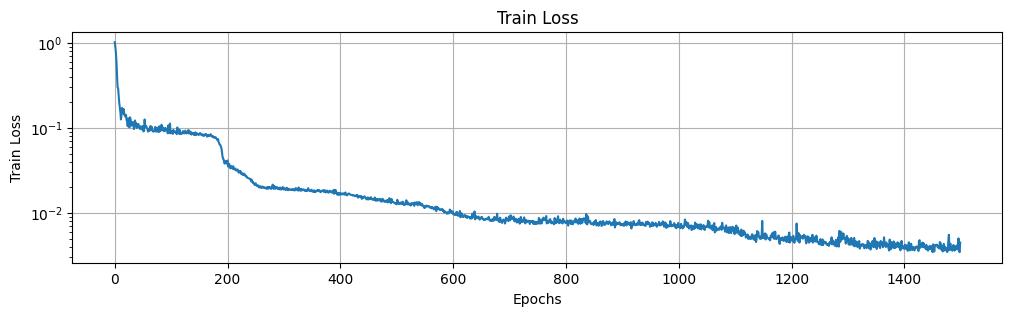

In [ ]:
# Train the dynamics model
LATENT_DIM = 16
NUM_CHANNELS = 1
BETA = 0.0001
# BETA = 0.001
LR = 0.001
# LR = 0.0001
NUM_EPOCHS = 1500

vae_model = StateVAE(latent_dim=LATENT_DIM, num_channels=NUM_CHANNELS)
loss_func = VAELoss(beta=BETA)
optimizer = optim.Adam(vae_model.parameters(), lr=LR)

train_loader, val_loader, normalization_constants = process_data_multiple_step(collected_data[0:1], num_steps=1) # Single step data

# leekt
vae_model.train()

pbar = tqdm(range(NUM_EPOCHS))
train_losses = []
for epoch_i in pbar:
    train_loss_i = 0.
    # TODO: You should implement the training step. You need to call the encoder and the decoder a
    # --- Your code here
    for batch_idx, sample in enumerate(train_loader):
      # print("batch_idx = ", batch_idx)
      states = sample["states"]
      reconstructed_states, mu, log_var, latent_state = vae_model(states)

      optimizer.zero_grad()
      loss = loss_func(reconstructed_states, states, mu, log_var)
      # print("loss = ", loss)
      loss.backward()
      optimizer.step()

      train_loss_i = loss.item()


    # ---
    pbar.set_description(f'Train Loss: {train_loss_i:.4f}')
    train_losses.append(train_loss_i)

# plot train loss and test loss:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
axes = [axes]
axes[0].plot(train_losses)
axes[0].grid()
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')
axes[0].set_yscale('log')



Text(0.5, 1.0, 'Reconstructed State')

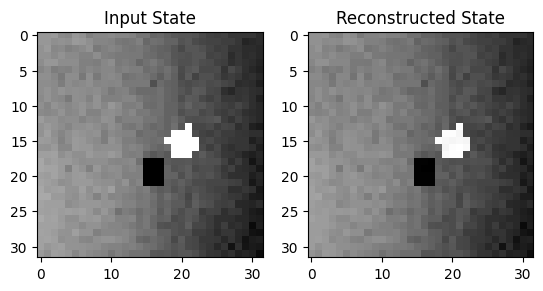

In [ ]:
# Visualize the state and its reconstruction:
vae_model.eval()
batches = [b for b in val_loader]
norm_tr = NormalizationTransform(norm_constants)
state = batches[0]['states'][0,0]
z, log_var = vae_model.encoder(state)
state_rec = vae_model.decoder(z)
state_img = norm_tr.denormalize_state(state).detach().cpu().numpy().transpose(1,2,0).astype(np.uint8)
state_rec_img = norm_tr.denormalize_state(state_rec).detach().cpu().numpy().transpose(1,2,0).astype(np.uint8)

fig, axes = plt.subplots(1,2)
axes[0].imshow(state_img, cmap='gray')
axes[0].set_title('Input State')
axes[1].imshow(state_rec_img, cmap='gray')
axes[1].set_title('Reconstructed State')

If everything is fine, you should obtain a near-perfect reconstruction since the network has been able to memorize the single state.

## 3.2 - VAE Training  (20 points)

Next, once you know that your VAE implementation is working, you will have to train it on the full set of data.

In [ ]:
# Train the VAE

LR = 0.0001
NUM_EPOCHS = 500
# NUM_EPOCHS = 2000
BETA = 0.001
LATENT_DIM = 10
NUM_CHANNELS = 1
NUM_STEPS = 1
LATENT_DIM = 16

train_loader, val_loader, norm_constants = process_data_multiple_step(collected_data, num_steps=1)
norm_tr = NormalizationTransform(norm_constants)

all_states = []
for batch_i in train_loader:
    state_i = batch_i['states']
    all_states.append(state_i)
all_states = torch.cat(all_states, axis=0)

states = all_states.flatten(end_dim=1) # Get initial states (Num satates, num_channels, w, h)


vae_model = StateVAE(latent_dim=LATENT_DIM, num_channels=1)
loss_func = VAELoss(beta=BETA)
optimizer = optim.Adam(vae_model.parameters(), lr=LR)
pbar = tqdm(range(NUM_EPOCHS))
train_losses = []
for epoch_i in pbar:
    train_loss_i = 0.
    # --- Your code here
    for batch_idx, sample in enumerate(train_loader):
      # print("batch_idx = ", batch_idx)
      states_batch = sample["states"]
      reconstructed_states, mu, log_var, latent_state = vae_model(states_batch)

      optimizer.zero_grad()
      loss = loss_func(reconstructed_states, states_batch, mu, log_var)
      # print("loss = ", loss)
      loss.backward()
      optimizer.step()

      # train_loss_i = loss.item()


    # ---
    train_loss_i += loss.item()
    pbar.set_description(f'Latent dim {LATENT_DIM} - Loss: {train_loss_i:.4f}')
    train_losses.append(train_loss_i)

losses = train_losses
vaes = vae_model
# Evaluate:
vae_model.eval()
states_rec, mu, log_var, latent_state = vae_model(states)


# plot train loss and test loss:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
axes = [axes]
axes[0].plot(losses, label=f'latent_dim: {LATENT_DIM}')
axes[0].grid()
axes[0].legend()
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')
axes[0].set_yscale('log')


# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'vae_model.pt')
torch.save(vae_model.state_dict(), save_path)

mean =  tensor([180.6437])
std =  tensor([17.0322])


Latent dim 16 - Loss: 0.1865:  52%|█████▏    | 258/500 [01:27<01:21,  2.95it/s]


KeyboardInterrupt: ignored

In [ ]:
# Visualize the state and its reconstruction:
num_states_to_plot = 10
fig, axes = plt.subplots(2, num_states_to_plot, sharex=True, sharey=True, figsize=(2*num_states_to_plot, 4))
axes = np.transpose(axes)
for s_i in range(num_states_to_plot):
    state_i = states[s_i]
    # leekt debug
    # print("state_i.shape = ", state_i.shape)
    # test_state_img = norm_tr.denormalize_state(state_i).detach().cpu().numpy().astype(np.uint8)
    # print("test_state_img.shape = ", test_state_img.shape)

    state_img = norm_tr.denormalize_state(state_i).detach().cpu().numpy().transpose(1,2,0).astype(np.uint8)
    axes[s_i][0].imshow(state_img, cmap='gray')
    axes[s_i][0].set_title('Input State')
    state_rec_i = states_rec[s_i]
    state_rec_img = norm_tr.denormalize_state(state_rec_i).detach().cpu().numpy().transpose(1,2,0).astype(np.uint8)
    axes[s_i][1].imshow(state_rec_img, cmap='gray')
    axes[s_i][1].set_title(f'Reconstruction')

## Test performance

**GRADING GUIDE**: We will evaluate your vae model performance on the `pushing_image_validation_data`. You should obtain a loss of 0.2 or lower.

In [ ]:
test_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_image_validation_data.npy'), allow_pickle=True)
norm_tr = NormalizationTransform(norm_constants)

single_step_dataset = MultiStepDynamicsDataset(test_data, num_steps=1, transform=norm_tr)
single_step_loader = DataLoader(single_step_dataset, batch_size=len(single_step_dataset))

loss_func = VAELoss(beta=BETA)

def test_vae(model, val_loader, loss_fn) -> float:
    """
    Perfoms an epoch of model performance validation
    :param model: Pytorch nn.Module
    :param train_loader: Pytorch DataLoader
    :param loss: Loss function
    :return: val_loss <float> representing the average loss among the different mini-batches
    """
    val_loss = 0. # TODO: Modify the value
    # Initialize the validation loop
    model.eval()
    for batch in val_loader:
        loss = None
        states = batch['states'].flatten(end_dim=1)
        states_rec, mu, log_var, latent_state = vae_model.forward(states)
        loss = loss_func(states_rec, states, mu, log_var)
        val_loss += loss.item()
    return val_loss/len(val_loader)


print(f'VAE model VALIDATION loss: {test_vae(vae_model, single_step_loader, loss_func)}')


# 4 -  Learn Latent Dynamics  (30 points)

Previously you implemented a VAE to reconstruct the images. In this section you will have to implement and train a dynamics model from images.

You will implemented an Autoencoder and learn dynamics in the latent space of that autoencoder. 
### Architecture

As you have seen in class, there exist more sophisticated approaches such as Embed to Control (E2C) which use VAEs to obtain the latent vectors. E2C imposes more structure on the latent which makes it less prone to create predictions out of distribution. However, E2C has extra complexity, requires larger data samples, and take more time to train. Hence, for simplification here we will simplify the model to an encoder-decoder.

The full architecture is shown below:

![latent_dynamics_architecture](https://drive.google.com/uc?export=view&id=1cfXQvphGVWxeygowyXMtI63TkGEcCepN)

The model components are as follows:

First, you will have to implement a state encoder, which maps images into latent vectors. The desired architecture is very similar to the VAE encoder you implemented in the previosu question, but is now deterministic. The architecture is as follows:

![state_encoder_architecture](https://drive.google.com/uc?export=view&id=1zsECGD0SPXXfeYY-sx5X8wJcVk-HhiKe)

Next, you will have the dynamics model in the latent space. You should use exactly the same residual dynamics architecture you have used in both HW3 and HW4 for this. 

Finally there is the decoder. For the decoder we will use the decoder class you implemented for the VAE. 


### Loss Function

We will use a multi-step loss function to train the autoencoder and the latent dynamics model end-to-end. A single training trajectory is given by a sequence of images $x_0, x_1, ..., x_T$, and controls $a_0, ..., a_{T-1}$. We encoder **every** image to a latent vector $z$ with the encoder to produce $z_0, z_1, ..., z_T$. In other words, $z_{t} = \texttt{encode}(x_t)$.

From the initial latent state $z_0$ we apply the latent dynamics model **recursively**, i.e. $\hat{z}_{1} = f_{latent}(z_0, a_0)$, $\hat{z}_{2} = f_{latent}(\hat{z}_1, a_1)$ and so on. This produces predictions $\hat{z}_1, ..., \hat{z}_T$. Similarly, we do the same for states. Starting at $x_0$, we propagate state dynamics to produce $\hat{x}_1, ..., \hat{x}_T$, where $\hat{x}_{t+1} = f_\text{dyn}(\hat{x}_t, a_t)$, and $\hat{x}_{1} = f_\text{dyn}(x_0, a_0)$.

The full loss is then:

$$
    \frac{1}{T+1}\sum^T_{t=0} ||x_t - \texttt{decode}(z_t)||^2 + \frac{1}{T}\sum_{t=1}^T ||x_t - \hat x_{t}||^2 + \frac{\alpha}{T} \sum^T_{t=1} ||z_t - \hat{z}_t||^2
$$

$\alpha$ is a hyperparameter and should be set to 0.1. This loss term has three components, the first is a standard reconstruction loss. The second two losses are both losses on the latent dynamics prediction. 

**TODO:**
* Implement `StateEncoder` in `learning_latent_dynamics.py`
    * Need to implement `__init__` and `forward` methods
* Implement `LatentDynamicsModel` in `learning_latent_dynamics.py`
    * Need to implement the methods `__init__`, `forward`, `encode`, `decode` and `latent_dynamics`.
* Implement `MultiStepLoss` in `learning_latent_dynamics.py`
    * Need to implement the `forward`.
    * Your MultiStepLoss should work for arbitrary `num_steps` in the dataset, including `num_steps=1`, i.e. a single-step loss.
    
    

## 4.1 - Learn Single Step Latent Dynamics  (15 points)

First you will train the model with a single-step loss. This is acheived by simply passing `num_steps=1` into `process_data_multiple_step`. 

You should be able to train the model to have validation loss of <0.25. You will need to submit your model `single_step_latent_dynamics_model.pt` to autograder. 

/content/drive/My Drive/ROB498_HW/Final_project/learning_latent_dynamics.py:258: DeprecationWarning: invalid escape sequence \m
  """


mean =  tensor([180.6437])
std =  tensor([17.0322])


  0%|          | 0/250 [00:00<?, ?it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 2.0557:   0%|          | 1/250 [00:00<02:20,  1.77it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300,

Latent dim 16 - Loss: 1.9198:   1%|          | 2/250 [00:01<02:19,  1.77it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 1.6998:   1%|          | 3/250 [00:01<02:50,  1.45it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 1.3875:   2%|▏         | 4/250 [00:02<03:04,  1.33it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 1.0139:   2%|▏         | 5/250 [00:03<03:05,  1.32it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.7525:   2%|▏         | 6/250 [00:04<02:43,  1.49it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.7675:   2%|▏         | 6/250 [00:04<02:43,  1.49it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.7675:   3%|▎         | 7/250 [00:04<02:34,  1.57it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.6371:   3%|▎         | 8/250 [00:05<03:12,  1.26it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.5009:   3%|▎         | 8/250 [00:06<03:12,  1.26it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.5009:   4%|▎         | 9/250 [00:06<02:58,  1.35it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.4915:   4%|▎         | 9/250 [00:06<02:58,  1.35it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.4915:   4%|▍         | 10/250 [00:06<02:43,  1.46it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.4997:   4%|▍         | 10/250 [00:07<02:43,  1.46it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.4997:   4%|▍         | 11/250 [00:07<02:35,  1.54it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.5009:   5%|▍         | 12/250 [00:08<02:29,  1.59it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.5001:   5%|▌         | 13/250 [00:08<02:25,  1.63it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4833:   6%|▌         | 14/250 [00:09<02:10,  1.80it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4806:   6%|▌         | 15/250 [00:09<02:01,  1.93it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4598:   6%|▋         | 16/250 [00:09<01:55,  2.03it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4519:   7%|▋         | 17/250 [00:10<01:50,  2.11it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4440:   7%|▋         | 18/250 [00:10<01:46,  2.19it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3


Latent dim 16 - Loss: 0.4362:   8%|▊         | 19/250 [00:11<01:42,  2.25it/s]

pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.4286:   8%|▊         | 20/250 [00:11<01:40,  2.28it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.4304:   8%|▊         | 21/250 [00:12<01:40,  2.29it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4253:   9%|▉         | 22/250 [00:12<01:39,  2.28it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4308:   9%|▉         | 23/250 [00:12<01:38,  2.30it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4259:  10%|▉         | 24/250 [00:13<01:37,  2.33it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4294:  10%|█         | 25/250 [00:13<01:38,  2.30it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.4160:  10%|█         | 26/250 [00:14<01:38,  2.27it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4267:  11%|█         | 27/250 [00:14<01:38,  2.27it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4203:  11%|█         | 28/250 [00:15<01:36,  2.30it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4151:  12%|█▏        | 29/250 [00:15<01:36,  2.30it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4211:  12%|█▏        | 30/250 [00:16<01:35,  2.31it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4114:  12%|█▏        | 31/250 [00:16<01:35,  2.30it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4049:  13%|█▎        | 32/250 [00:16<01:34,  2.31it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4095:  13%|█▎        | 33/250 [00:17<01:35,  2.28it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4110:  14%|█▎        | 34/250 [00:17<01:35,  2.27it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.4163:  14%|█▍        | 35/250 [00:18<01:34,  2.29it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3989:  14%|█▍        | 36/250 [00:18<01:34,  2.28it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.4014:  15%|█▍        | 37/250 [00:19<01:42,  2.07it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300,

Latent dim 16 - Loss: 0.4088:  15%|█▌        | 38/250 [00:19<01:48,  1.96it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3962:  15%|█▌        | 38/250 [00:20<01:48,  1.96it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3962:  16%|█▌        | 39/250 [00:20<01:51,  1.90it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3868:  16%|█▌        | 40/250 [00:20<01:53,  1.86it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300,

Latent dim 16 - Loss: 0.3935:  16%|█▋        | 41/250 [00:21<01:54,  1.82it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3931:  17%|█▋        | 42/250 [00:22<01:56,  1.78it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3822:  17%|█▋        | 43/250 [00:22<01:57,  1.76it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3887:  18%|█▊        | 44/250 [00:23<01:56,  1.76it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3945:  18%|█▊        | 45/250 [00:23<01:48,  1.88it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3835:  18%|█▊        | 46/250 [00:24<01:43,  1.97it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3943:  19%|█▉        | 47/250 [00:24<01:37,  2.08it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3923:  19%|█▉        | 48/250 [00:24<01:33,  2.15it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3808:  20%|█▉        | 49/250 [00:25<01:29,  2.23it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3800:  20%|██        | 50/250 [00:25<01:28,  2.26it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3823:  20%|██        | 51/250 [00:26<01:27,  2.28it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3861:  21%|██        | 52/250 [00:26<01:27,  2.27it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3857:  21%|██        | 53/250 [00:27<01:25,  2.31it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3846:  22%|██▏       | 54/250 [00:27<01:24,  2.33it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3788:  22%|██▏       | 55/250 [00:28<01:25,  2.28it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3879:  22%|██▏       | 56/250 [00:28<01:23,  2.31it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3727:  23%|██▎       | 57/250 [00:28<01:24,  2.29it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3843:  23%|██▎       | 58/250 [00:29<01:24,  2.28it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3723:  24%|██▎       | 59/250 [00:29<01:23,  2.29it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3687:  24%|██▍       | 60/250 [00:30<01:23,  2.29it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3804:  24%|██▍       | 61/250 [00:30<01:22,  2.29it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3793:  25%|██▍       | 62/250 [00:31<01:21,  2.31it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3688:  25%|██▌       | 63/250 [00:31<01:19,  2.36it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])


Latent dim 16 - Loss: 0.3919:  26%|██▌       | 64/250 [00:31<01:18,  2.36it/s]

prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3726:  26%|██▌       | 65/250 [00:32<01:20,  2.30it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3791:  26%|██▋       | 66/250 [00:32<01:19,  2.32it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3752:  27%|██▋       | 67/250 [00:33<01:19,  2.30it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shap

Latent dim 16 - Loss: 0.3656:  27%|██▋       | 68/250 [00:33<01:28,  2.06it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3790:  28%|██▊       | 69/250 [00:34<01:31,  1.97it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300,

Latent dim 16 - Loss: 0.3746:  28%|██▊       | 70/250 [00:34<01:34,  1.90it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3678:  28%|██▊       | 71/250 [00:35<01:36,  1.86it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3766:  29%|██▉       | 72/250 [00:36<01:36,  1.85it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3689:  29%|██▉       | 72/250 [00:36<01:36,  1.85it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3689:  29%|██▉       | 73/250 [00:36<01:37,  1.82it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3795:  30%|██▉       | 74/250 [00:37<01:38,  1.79it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3759:  30%|███       | 75/250 [00:37<01:35,  1.83it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3778:  30%|███       | 76/250 [00:38<01:28,  1.96it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3773:  31%|███       | 77/250 [00:38<01:23,  2.06it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3829:  31%|███       | 78/250 [00:38<01:20,  2.14it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3627:  32%|███▏      | 79/250 [00:39<01:18,  2.19it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3697:  32%|███▏      | 80/250 [00:39<01:16,  2.22it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3685:  32%|███▏      | 81/250 [00:40<01:15,  2.24it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3784:  33%|███▎      | 82/250 [00:40<01:13,  2.28it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3723:  33%|███▎      | 83/250 [00:41<01:24,  1.98it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300,

Latent dim 16 - Loss: 0.3626:  34%|███▎      | 84/250 [00:42<01:30,  1.84it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3756:  34%|███▍      | 85/250 [00:42<01:27,  1.89it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3606:  34%|███▍      | 86/250 [00:42<01:21,  2.02it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3767:  35%|███▍      | 87/250 [00:43<01:18,  2.08it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3662:  35%|███▌      | 88/250 [00:43<01:15,  2.13it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3652:  36%|███▌      | 89/250 [00:44<01:13,  2.20it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3676:  36%|███▌      | 90/250 [00:44<01:12,  2.21it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3645:  36%|███▋      | 91/250 [00:45<01:10,  2.25it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3664:  37%|███▋      | 92/250 [00:45<01:09,  2.28it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3569:  37%|███▋      | 93/250 [00:45<01:08,  2.30it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3649:  38%|███▊      | 94/250 [00:46<01:09,  2.26it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3666:  38%|███▊      | 95/250 [00:46<01:08,  2.25it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3590:  38%|███▊      | 96/250 [00:47<01:07,  2.27it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3611:  39%|███▉      | 97/250 [00:47<01:09,  2.21it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shap

Latent dim 16 - Loss: 0.3598:  39%|███▉      | 98/250 [00:48<01:14,  2.03it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3615:  40%|███▉      | 99/250 [00:49<01:27,  1.73it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3568:  40%|████      | 100/250 [00:49<01:25,  1.76it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3533:  40%|████      | 100/250 [00:50<01:25,  1.76it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3533:  40%|████      | 101/250 [00:50<01:26,  1.73it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3553:  41%|████      | 102/250 [00:50<01:25,  1.74it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3709:  41%|████      | 103/250 [00:51<01:25,  1.72it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3580:  42%|████▏     | 104/250 [00:51<01:22,  1.76it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3564:  42%|████▏     | 105/250 [00:52<01:17,  1.87it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3642:  42%|████▏     | 106/250 [00:52<01:14,  1.94it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3568:  43%|████▎     | 107/250 [00:53<01:10,  2.02it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3483:  43%|████▎     | 108/250 [00:53<01:07,  2.09it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1


Latent dim 16 - Loss: 0.3459:  44%|████▎     | 109/250 [00:54<01:04,  2.19it/s]

pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3545:  44%|████▍     | 110/250 [00:54<01:02,  2.23it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3489:  44%|████▍     | 111/250 [00:55<01:01,  2.27it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3436:  45%|████▍     | 112/250 [00:55<01:01,  2.26it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3554:  45%|████▌     | 113/250 [00:55<01:00,  2.27it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3342:  46%|████▌     | 114/250 [00:56<00:58,  2.31it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3427:  46%|████▌     | 115/250 [00:56<00:58,  2.31it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3415:  46%|████▋     | 116/250 [00:57<00:58,  2.30it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3370:  47%|████▋     | 117/250 [00:57<00:58,  2.26it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3399:  47%|████▋     | 118/250 [00:58<00:58,  2.26it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3253:  48%|████▊     | 119/250 [00:58<00:58,  2.24it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3298:  48%|████▊     | 120/250 [00:59<00:57,  2.25it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3256:  48%|████▊     | 121/250 [00:59<00:57,  2.26it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3289:  49%|████▉     | 122/250 [00:59<00:56,  2.26it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3239:  49%|████▉     | 123/250 [01:00<00:56,  2.27it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3347:  50%|████▉     | 124/250 [01:00<00:55,  2.29it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3292:  50%|█████     | 125/250 [01:01<00:54,  2.30it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3259:  50%|█████     | 126/250 [01:01<00:53,  2.30it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shap

Latent dim 16 - Loss: 0.3258:  51%|█████     | 127/250 [01:02<00:56,  2.16it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3279:  51%|█████     | 128/250 [01:02<01:00,  2.01it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3147:  52%|█████▏    | 129/250 [01:03<01:02,  1.94it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3274:  52%|█████▏    | 130/250 [01:03<01:04,  1.86it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3173:  52%|█████▏    | 131/250 [01:04<01:04,  1.84it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3171:  53%|█████▎    | 132/250 [01:05<01:04,  1.82it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3098:  53%|█████▎    | 133/250 [01:05<01:05,  1.78it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3106:  53%|█████▎    | 133/250 [01:06<01:05,  1.78it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.3106:  54%|█████▎    | 134/250 [01:06<01:05,  1.76it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.3011:  54%|█████▍    | 135/250 [01:06<01:01,  1.88it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3157:  54%|█████▍    | 136/250 [01:07<00:57,  1.98it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2


Latent dim 16 - Loss: 0.3129:  55%|█████▍    | 137/250 [01:07<00:53,  2.11it/s]

pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2958:  55%|█████▌    | 138/250 [01:07<00:51,  2.16it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2981:  56%|█████▌    | 139/250 [01:08<00:50,  2.21it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2960:  56%|█████▌    | 140/250 [01:08<00:49,  2.22it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.3085:  56%|█████▋    | 141/250 [01:09<00:47,  2.30it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2966:  57%|█████▋    | 142/250 [01:09<00:47,  2.28it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2869:  57%|█████▋    | 143/250 [01:10<00:47,  2.26it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2847:  58%|█████▊    | 144/250 [01:10<00:46,  2.27it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2917:  58%|█████▊    | 145/250 [01:10<00:47,  2.23it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2831:  58%|█████▊    | 146/250 [01:11<00:50,  2.06it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2773:  59%|█████▉    | 147/250 [01:12<00:52,  1.94it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2817:  59%|█████▉    | 148/250 [01:12<00:50,  2.04it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2698:  60%|█████▉    | 149/250 [01:13<00:47,  2.11it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2698:  60%|██████    | 150/250 [01:13<00:45,  2.17it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])

Latent dim 16 - Loss: 0.2745:  60%|██████    | 151/250 [01:13<00:44,  2.22it/s]


t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2704:  61%|██████    | 152/250 [01:14<00:44,  2.21it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2674:  61%|██████    | 153/250 [01:14<00:44,  2.20it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2588:  62%|██████▏   | 154/250 [01:15<00:43,  2.20it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2653:  62%|██████▏   | 155/250 [01:15<00:42,  2.23it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2610:  62%|██████▏   | 156/250 [01:16<00:42,  2.24it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shap

Latent dim 16 - Loss: 0.2622:  63%|██████▎   | 157/250 [01:16<00:44,  2.08it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2549:  63%|██████▎   | 157/250 [01:17<00:44,  2.08it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.2549:  63%|██████▎   | 158/250 [01:17<00:46,  1.96it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2580:  64%|██████▎   | 159/250 [01:17<00:47,  1.90it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300,

Latent dim 16 - Loss: 0.2491:  64%|██████▍   | 160/250 [01:18<00:48,  1.84it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.2460:  64%|██████▍   | 161/250 [01:18<00:48,  1.82it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.2466:  65%|██████▍   | 162/250 [01:19<00:49,  1.76it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2437:  65%|██████▌   | 163/250 [01:20<00:48,  1.79it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300,

Latent dim 16 - Loss: 0.2411:  66%|██████▌   | 164/250 [01:20<00:48,  1.78it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2359:  66%|██████▌   | 165/250 [01:21<00:46,  1.84it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2419:  66%|██████▋   | 166/250 [01:21<00:43,  1.95it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2322:  67%|██████▋   | 167/250 [01:22<00:40,  2.05it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2309:  67%|██████▋   | 168/250 [01:22<00:38,  2.11it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2237:  68%|██████▊   | 169/250 [01:22<00:37,  2.14it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2224:  68%|██████▊   | 170/250 [01:23<00:37,  2.13it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2208:  68%|██████▊   | 171/250 [01:23<00:36,  2.17it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2120:  69%|██████▉   | 172/250 [01:24<00:35,  2.22it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2265:  69%|██████▉   | 173/250 [01:24<00:34,  2.20it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2175:  70%|██████▉   | 174/250 [01:25<00:34,  2.22it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2170:  70%|███████   | 175/250 [01:25<00:36,  2.07it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...

Latent dim 16 - Loss: 0.2207:  70%|███████   | 176/250 [01:26<00:34,  2.12it/s]


T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2131:  71%|███████   | 177/250 [01:26<00:33,  2.15it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2110:  71%|███████   | 178/250 [01:27<00:33,  2.17it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2043:  72%|███████▏  | 179/250 [01:27<00:32,  2.18it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2084:  72%|███████▏  | 180/250 [01:27<00:31,  2.21it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2032:  72%|███████▏  | 181/250 [01:28<00:31,  2.18it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2054:  73%|███████▎  | 182/250 [01:28<00:30,  2.22it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.2044:  73%|███████▎  | 183/250 [01:29<00:30,  2.19it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1999:  74%|███████▎  | 184/250 [01:29<00:30,  2.17it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.2016:  74%|███████▍  | 185/250 [01:30<00:29,  2.21it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1958:  74%|███████▍  | 186/250 [01:30<00:28,  2.21it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1991:  74%|███████▍  | 186/250 [01:31<00:28,  2.21it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.1991:  75%|███████▍  | 187/250 [01:31<00:29,  2.14it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1963:  75%|███████▌  | 188/250 [01:31<00:30,  2.05it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300,

Latent dim 16 - Loss: 0.1966:  76%|███████▌  | 189/250 [01:32<00:31,  1.94it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.1942:  76%|███████▌  | 190/250 [01:32<00:32,  1.87it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.1934:  76%|███████▋  | 191/250 [01:33<00:32,  1.81it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.1954:  77%|███████▋  | 192/250 [01:34<00:32,  1.77it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1878:  77%|███████▋  | 193/250 [01:34<00:33,  1.72it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300,

Latent dim 16 - Loss: 0.1908:  78%|███████▊  | 194/250 [01:35<00:32,  1.71it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1893:  78%|███████▊  | 195/250 [01:35<00:30,  1.79it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1903:  78%|███████▊  | 196/250 [01:36<00:28,  1.92it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1947:  79%|███████▉  | 197/250 [01:36<00:26,  1.99it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1792:  79%|███████▉  | 198/250 [01:37<00:25,  2.07it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1829:  80%|███████▉  | 199/250 [01:37<00:24,  2.11it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1862:  80%|████████  | 200/250 [01:38<00:23,  2.16it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1807:  80%|████████  | 201/250 [01:38<00:22,  2.18it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1789:  81%|████████  | 202/250 [01:38<00:22,  2.18it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1770:  81%|████████  | 203/250 [01:39<00:21,  2.20it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1741:  82%|████████▏ | 204/250 [01:39<00:20,  2.22it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1811:  82%|████████▏ | 205/250 [01:40<00:20,  2.24it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1760:  82%|████████▏ | 206/250 [01:40<00:19,  2.24it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1772:  83%|████████▎ | 207/250 [01:41<00:19,  2.24it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1729:  83%|████████▎ | 208/250 [01:41<00:18,  2.23it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1705:  84%|████████▎ | 209/250 [01:42<00:18,  2.24it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1698:  84%|████████▍ | 210/250 [01:42<00:17,  2.26it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1655:  84%|████████▍ | 211/250 [01:42<00:17,  2.27it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1605:  85%|████████▍ | 212/250 [01:43<00:16,  2.25it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1669:  85%|████████▌ | 213/250 [01:43<00:16,  2.24it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1676:  86%|████████▌ | 214/250 [01:44<00:15,  2.27it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1693:  86%|████████▌ | 215/250 [01:44<00:15,  2.22it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1617:  86%|████████▋ | 216/250 [01:45<00:15,  2.24it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shap

Latent dim 16 - Loss: 0.1629:  87%|████████▋ | 217/250 [01:45<00:15,  2.15it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1686:  87%|████████▋ | 218/250 [01:46<00:15,  2.06it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300,

Latent dim 16 - Loss: 0.1610:  88%|████████▊ | 219/250 [01:46<00:16,  1.92it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.1616:  88%|████████▊ | 220/250 [01:47<00:16,  1.87it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1636:  88%|████████▊ | 220/250 [01:47<00:16,  1.87it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.1636:  88%|████████▊ | 221/250 [01:47<00:15,  1.85it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1603:  88%|████████▊ | 221/250 [01:48<00:15,  1.85it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.1603:  89%|████████▉ | 222/250 [01:48<00:15,  1.81it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1580:  89%|████████▉ | 222/250 [01:49<00:15,  1.81it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.1580:  89%|████████▉ | 223/250 [01:49<00:15,  1.78it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.1582:  90%|████████▉ | 224/250 [01:49<00:14,  1.76it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1574:  90%|█████████ | 225/250 [01:50<00:14,  1.78it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1576:  90%|█████████ | 226/250 [01:50<00:12,  1.89it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1576:  91%|█████████ | 227/250 [01:51<00:11,  1.98it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1583:  91%|█████████ | 228/250 [01:51<00:10,  2.06it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1531:  92%|█████████▏| 229/250 [01:52<00:09,  2.11it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1558:  92%|█████████▏| 230/250 [01:52<00:09,  2.19it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1544:  92%|█████████▏| 231/250 [01:52<00:08,  2.17it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1577:  93%|█████████▎| 232/250 [01:53<00:08,  2.18it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1582:  93%|█████████▎| 233/250 [01:53<00:07,  2.16it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1502:  94%|█████████▎| 234/250 [01:54<00:07,  2.23it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1501:  94%|█████████▍| 235/250 [01:54<00:06,  2.22it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...

Latent dim 16 - Loss: 0.1482:  94%|█████████▍| 236/250 [01:55<00:06,  2.21it/s]


T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1537:  95%|█████████▍| 237/250 [01:55<00:05,  2.23it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1525:  95%|█████████▌| 238/250 [01:56<00:05,  2.25it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1531:  96%|█████████▌| 239/250 [01:56<00:04,  2.28it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1482:  96%|█████████▌| 240/250 [01:56<00:04,  2.26it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1546:  96%|█████████▋| 241/250 [01:57<00:04,  2.25it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1457:  97%|█████████▋| 242/250 [01:57<00:03,  2.27it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T = 

Latent dim 16 - Loss: 0.1554:  97%|█████████▋| 243/250 [01:58<00:03,  2.27it/s]

 1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1523:  98%|█████████▊| 244/250 [01:58<00:02,  2.24it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1498:  98%|█████████▊| 245/250 [01:59<00:02,  2.19it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1529:  98%|█████████▊| 246/250 [01:59<00:01,  2.23it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1


Latent dim 16 - Loss: 0.1418:  99%|█████████▉| 247/250 [02:00<00:01,  2.19it/s]

prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])


Latent dim 16 - Loss: 0.1427:  99%|█████████▉| 247/250 [02:00<00:01,  2.19it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.1427:  99%|█████████▉| 248/250 [02:00<00:00,  2.05it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.1441: 100%|█████████▉| 249/250 [02:01<00:00,  1.91it/s]

calculating loss...
T =  1
prev_z.shape =  torch.Size([500, 16])
prev_x.shape =  torch.Size([500, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([500, 16])
2
pred_z.shape =  torch.Size([500, 16])
3
pred_x.shape =  torch.Size([500, 1, 32, 32])
4
pred_dx.shape =  torch.Size([500, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([500, 16])
pred_dx.shape =  torch.Size([500, 1, 32, 32])
calculating loss...
T =  1
prev_z.shape =  torch.Size([300, 16])
prev_x.shape =  torch.Size([300, 1, 32, 32])
t =  0
1
pred_dz.shape =  torch.Size([300, 16])
2
pred_z.shape =  torch.Size([300, 16])
3
pred_x.shape =  torch.Size([300, 1, 32, 32])
4
pred_dx.shape =  torch.Size([300, 1, 32, 32])
5
6
7
pred_dz.shape =  torch.Size([300, 16])
pred_dx.shape =  torch.Size([300, 1, 32, 32])


Latent dim 16 - Loss: 0.1484: 100%|██████████| 250/250 [02:01<00:00,  2.05it/s]


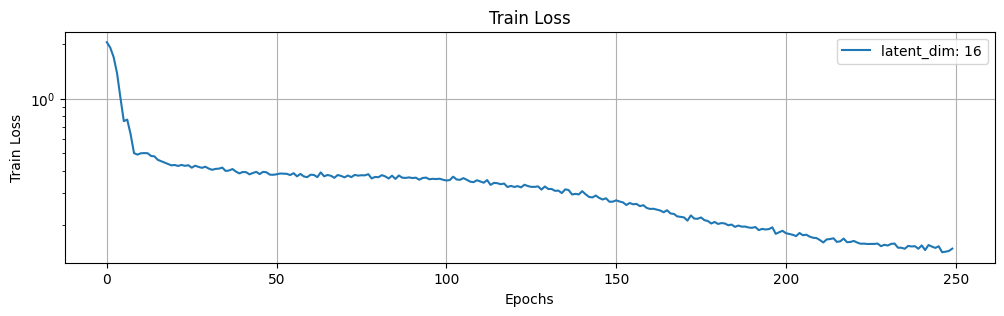

In [15]:
# Train the dynamics model

LATENT_DIM = 16
ACTION_DIM = 3
NUM_CHANNELS = 1
NUM_STEPS = 1

single_step_latent_dynamics_model = SINDyDynamicsModel(latent_dim=LATENT_DIM, action_dim=ACTION_DIM, num_channels=NUM_CHANNELS)
# single_step_latent_dynamics_model = LatentDynamicsModel(latent_dim=LATENT_DIM, action_dim=ACTION_DIM, num_channels=NUM_CHANNELS)


# Compute normalization constants
train_loader, val_loader, norm_constants = process_data_multiple_step(collected_data, batch_size=500, num_steps=NUM_STEPS)
norm_tr = NormalizationTransform(norm_constants)

state_loss_fn = nn.MSELoss()
latent_loss_fn = nn.MSELoss()
multistep_loss = SINDyLoss(state_loss_fn, latent_loss_fn)
# multistep_loss = MultiStepLoss(state_loss_fn, latent_loss_fn, alpha=0.1)

# TODO: Train latent_dynamics_model
# --- Your code here
NUM_EPOCHS = 250
LR = 0.7 * 1e-3


optimizer = optim.Adam(single_step_latent_dynamics_model.parameters(), lr=LR)
pbar = tqdm(range(NUM_EPOCHS))
train_losses = []
for epoch_i in pbar:
    train_loss_i = 0.
    # --- Your code here
    for batch_idx, sample in enumerate(train_loader):
      # print("batch_idx = ", batch_idx)
      states_batch, actions_batch = sample["states"], sample["actions"]

      optimizer.zero_grad()
      print("calculating loss...")
      loss = multistep_loss(single_step_latent_dynamics_model, states_batch, actions_batch)
      loss.backward()
      optimizer.step()
      
    # ---
    train_loss_i += loss.item()
    pbar.set_description(f'Latent dim {LATENT_DIM} - Loss: {train_loss_i:.4f}')
    train_losses.append(train_loss_i)

losses = train_losses
# vaes = vae_model
# # Evaluate:
# vae_model.eval()
# states_rec, mu, log_var, latent_state = vae_model(states)


# plot train loss and test loss:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
axes = [axes]
axes[0].plot(losses, label=f'latent_dim: {LATENT_DIM}')
axes[0].grid()
axes[0].legend()
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')
axes[0].set_yscale('log')


# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'single_step_latent_dynamics_model.pt')
torch.save(single_step_latent_dynamics_model.state_dict(), save_path)

dx.shape =  torch.Size([1, 16])
latent_state.shape =  torch.Size([1, 16])
next_latent_state.shape =  torch.Size([1, 16])
dx.shape =  torch.Size([1, 16])
latent_state.shape =  torch.Size([1, 16])
next_latent_state.shape =  torch.Size([1, 16])
dx.shape =  torch.Size([1, 16])
latent_state.shape =  torch.Size([1, 16])
next_latent_state.shape =  torch.Size([1, 16])
dx.shape =  torch.Size([1, 16])
latent_state.shape =  torch.Size([1, 16])
next_latent_state.shape =  torch.Size([1, 16])
dx.shape =  torch.Size([1, 16])
latent_state.shape =  torch.Size([1, 16])
next_latent_state.shape =  torch.Size([1, 16])
dx.shape =  torch.Size([1, 16])
latent_state.shape =  torch.Size([1, 16])
next_latent_state.shape =  torch.Size([1, 16])
dx.shape =  torch.Size([1, 16])
latent_state.shape =  torch.Size([1, 16])
next_latent_state.shape =  torch.Size([1, 16])
dx.shape =  torch.Size([1, 16])
latent_state.shape =  torch.Size([1, 16])
next_latent_state.shape =  torch.Size([1, 16])
dx.shape =  torch.Size([1, 16])


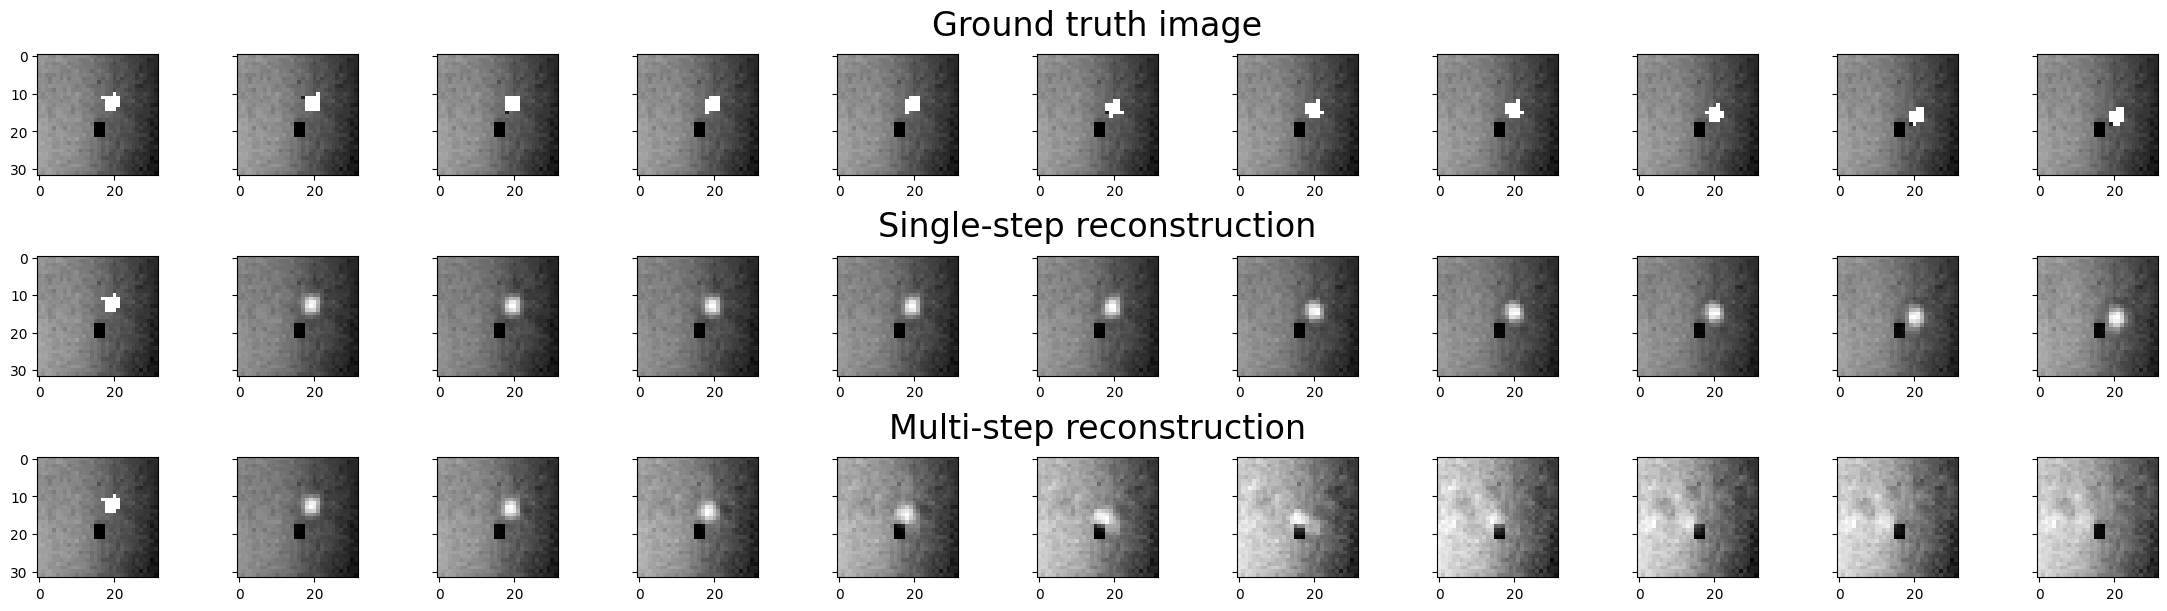

In [16]:
# Visualize the ability to perform single-step and multi-step state prediction:
traj = collected_data[0]
evaluate_model_plot(single_step_latent_dynamics_model, traj, norm_tr)

## 4.2 - Learn Multi-Step Dynamics  (15 points)

Now we will train using a multi-step loss by `num_steps=4` into `process_data_multiple_step`. 

You should be able to train the model to have validation loss of <0.25. You will need to submit your model `multi_step_latent_dynamics_model.pt` to autograder. 


mean =  tensor([180.6415])
std =  tensor([17.0344])


  0%|          | 0/500 [00:00<?, ?it/s]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 1.9668:   0%|          | 1/500 [00:01<10:52,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 1.8342:   0%|          | 2/500 [00:02<10:29,  1.26s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 1.6452:   1%|          | 3/500 [00:03<11:01,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 1.3494:   1%|          | 4/500 [00:05<10:38,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 1.0081:   1%|          | 5/500 [00:06<10:19,  1.25s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.7143:   1%|          | 6/500 [00:07<11:00,  1.34s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.6727:   1%|▏         | 7/500 [00:09<12:04,  1.47s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.5389:   2%|▏         | 8/500 [00:11<12:21,  1.51s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.4466:   2%|▏         | 9/500 [00:12<11:39,  1.42s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3905:   2%|▏         | 10/500 [00:13<11:14,  1.38s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.4299:   2%|▏         | 11/500 [00:14<10:43,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.4020:   2%|▏         | 12/500 [00:16<10:24,  1.28s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.4099:   3%|▎         | 13/500 [00:17<10:15,  1.26s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.4070:   3%|▎         | 14/500 [00:18<10:10,  1.26s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.4001:   3%|▎         | 15/500 [00:19<10:06,  1.25s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.4202:   3%|▎         | 16/500 [00:21<10:04,  1.25s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.4076:   3%|▎         | 17/500 [00:22<11:19,  1.41s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3949:   4%|▎         | 18/500 [00:24<12:11,  1.52s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3935:   4%|▍         | 19/500 [00:25<11:45,  1.47s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.4038:   4%|▍         | 20/500 [00:27<11:14,  1.41s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3549:   4%|▍         | 21/500 [00:28<10:54,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3727:   4%|▍         | 22/500 [00:29<10:36,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3749:   5%|▍         | 23/500 [00:30<10:16,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3829:   5%|▍         | 24/500 [00:32<10:03,  1.27s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3794:   5%|▌         | 25/500 [00:33<10:01,  1.27s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3996:   5%|▌         | 26/500 [00:34<09:56,  1.26s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3759:   5%|▌         | 27/500 [00:36<10:51,  1.38s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3692:   6%|▌         | 28/500 [00:38<11:40,  1.48s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3757:   6%|▌         | 29/500 [00:39<11:48,  1.50s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3737:   6%|▌         | 30/500 [00:40<11:13,  1.43s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3701:   6%|▌         | 31/500 [00:42<10:46,  1.38s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3797:   6%|▋         | 32/500 [00:43<10:25,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3623:   7%|▋         | 33/500 [00:44<10:13,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3725:   7%|▋         | 34/500 [00:45<10:06,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3620:   7%|▋         | 35/500 [00:47<09:59,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3673:   7%|▋         | 36/500 [00:48<09:54,  1.28s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.4175:   7%|▋         | 37/500 [00:49<10:27,  1.36s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3835:   8%|▊         | 38/500 [00:51<11:23,  1.48s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3473:   8%|▊         | 39/500 [00:53<11:42,  1.52s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3789:   8%|▊         | 40/500 [00:54<11:08,  1.45s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3714:   8%|▊         | 41/500 [00:55<10:40,  1.39s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3480:   8%|▊         | 42/500 [00:57<10:19,  1.35s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3629:   9%|▊         | 43/500 [00:58<10:04,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3826:   9%|▉         | 44/500 [00:59<09:55,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3538:   9%|▉         | 45/500 [01:00<09:42,  1.28s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3921:   9%|▉         | 46/500 [01:02<10:01,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3577:   9%|▉         | 47/500 [01:03<10:20,  1.37s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3845:  10%|▉         | 48/500 [01:05<11:11,  1.49s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3595:  10%|▉         | 49/500 [01:07<11:35,  1.54s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3804:  10%|█         | 50/500 [01:08<10:56,  1.46s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3836:  10%|█         | 51/500 [01:09<10:31,  1.41s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3966:  10%|█         | 52/500 [01:10<10:09,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3648:  11%|█         | 53/500 [01:12<09:53,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3701:  11%|█         | 54/500 [01:13<09:50,  1.32s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3827:  11%|█         | 55/500 [01:14<09:40,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3705:  11%|█         | 56/500 [01:16<09:34,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3522:  11%|█▏        | 57/500 [01:17<09:50,  1.33s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3687:  12%|█▏        | 58/500 [01:19<10:50,  1.47s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3714:  12%|█▏        | 59/500 [01:21<11:32,  1.57s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3531:  12%|█▏        | 60/500 [01:22<10:50,  1.48s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3554:  12%|█▏        | 61/500 [01:23<10:24,  1.42s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3973:  12%|█▏        | 62/500 [01:24<10:03,  1.38s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3679:  13%|█▎        | 63/500 [01:26<09:49,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3598:  13%|█▎        | 64/500 [01:27<09:40,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.4198:  13%|█▎        | 65/500 [01:28<09:29,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3781:  13%|█▎        | 66/500 [01:30<09:20,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3749:  13%|█▎        | 67/500 [01:31<09:25,  1.31s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3907:  14%|█▎        | 68/500 [01:33<10:21,  1.44s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3958:  14%|█▍        | 69/500 [01:34<10:59,  1.53s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3459:  14%|█▍        | 70/500 [01:36<10:35,  1.48s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3528:  14%|█▍        | 71/500 [01:37<10:07,  1.41s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3839:  14%|█▍        | 72/500 [01:38<09:46,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3565:  15%|█▍        | 73/500 [01:40<09:33,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3691:  15%|█▍        | 74/500 [01:41<09:18,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3270:  15%|█▌        | 75/500 [01:42<09:10,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3303:  15%|█▌        | 76/500 [01:43<09:04,  1.28s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3382:  15%|█▌        | 77/500 [01:45<08:57,  1.27s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3511:  16%|█▌        | 78/500 [01:46<09:56,  1.41s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3805:  16%|█▌        | 79/500 [01:48<10:37,  1.51s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3635:  16%|█▌        | 80/500 [01:49<10:27,  1.49s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3662:  16%|█▌        | 81/500 [01:51<09:52,  1.42s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3632:  16%|█▋        | 82/500 [01:52<09:37,  1.38s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3454:  17%|█▋        | 83/500 [01:53<09:19,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3284:  17%|█▋        | 84/500 [01:54<09:06,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3326:  17%|█▋        | 85/500 [01:56<08:54,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3121:  17%|█▋        | 86/500 [01:57<08:48,  1.28s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3527:  17%|█▋        | 87/500 [01:58<08:44,  1.27s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3392:  18%|█▊        | 88/500 [02:00<09:18,  1.36s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3282:  18%|█▊        | 89/500 [02:02<10:14,  1.50s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3443:  18%|█▊        | 90/500 [02:03<10:29,  1.54s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3293:  18%|█▊        | 91/500 [02:04<09:52,  1.45s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3537:  18%|█▊        | 92/500 [02:06<09:27,  1.39s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3417:  19%|█▊        | 93/500 [02:07<09:07,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3307:  19%|█▉        | 94/500 [02:08<09:00,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3546:  19%|█▉        | 95/500 [02:10<08:49,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3026:  19%|█▉        | 96/500 [02:11<08:39,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3677:  19%|█▉        | 97/500 [02:12<08:32,  1.27s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3391:  20%|█▉        | 98/500 [02:13<08:52,  1.32s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3350:  20%|█▉        | 99/500 [02:15<09:39,  1.44s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3003:  20%|██        | 100/500 [02:17<10:15,  1.54s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3164:  20%|██        | 101/500 [02:18<09:39,  1.45s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3051:  20%|██        | 102/500 [02:19<09:13,  1.39s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3025:  21%|██        | 103/500 [02:21<08:55,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2974:  21%|██        | 104/500 [02:22<08:44,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2958:  21%|██        | 105/500 [02:23<08:46,  1.33s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3089:  21%|██        | 106/500 [02:26<12:06,  1.84s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3229:  21%|██▏       | 107/500 [02:31<17:27,  2.66s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3451:  22%|██▏       | 108/500 [02:36<21:35,  3.30s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3052:  22%|██▏       | 109/500 [02:38<20:16,  3.11s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3080:  22%|██▏       | 110/500 [02:41<18:33,  2.85s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2943:  22%|██▏       | 111/500 [02:42<16:29,  2.54s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3112:  22%|██▏       | 112/500 [02:44<14:39,  2.27s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3028:  23%|██▎       | 113/500 [02:45<12:56,  2.01s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3133:  23%|██▎       | 114/500 [02:47<12:23,  1.93s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.3149:  23%|██▎       | 115/500 [02:49<12:07,  1.89s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2951:  23%|██▎       | 116/500 [02:50<10:52,  1.70s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3233:  23%|██▎       | 117/500 [02:52<09:59,  1.57s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3342:  24%|██▎       | 118/500 [02:53<09:21,  1.47s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3059:  24%|██▍       | 119/500 [02:54<08:52,  1.40s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2987:  24%|██▍       | 120/500 [02:55<08:36,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2687:  24%|██▍       | 121/500 [02:57<08:23,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3355:  24%|██▍       | 122/500 [02:58<08:15,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3093:  25%|██▍       | 123/500 [02:59<08:07,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3147:  25%|██▍       | 124/500 [03:01<08:58,  1.43s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2808:  25%|██▌       | 125/500 [03:03<09:32,  1.53s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2918:  25%|██▌       | 126/500 [03:04<09:24,  1.51s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2528:  25%|██▌       | 127/500 [03:05<08:53,  1.43s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2957:  26%|██▌       | 128/500 [03:06<08:30,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2742:  26%|██▌       | 129/500 [03:08<08:17,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2992:  26%|██▌       | 130/500 [03:09<08:12,  1.33s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2877:  26%|██▌       | 131/500 [03:10<08:00,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2832:  26%|██▋       | 132/500 [03:12<07:52,  1.28s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2902:  27%|██▋       | 133/500 [03:13<07:48,  1.28s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2924:  27%|██▋       | 134/500 [03:14<08:28,  1.39s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2774:  27%|██▋       | 135/500 [03:16<09:10,  1.51s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2763:  27%|██▋       | 136/500 [03:18<09:16,  1.53s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2667:  27%|██▋       | 137/500 [03:19<08:44,  1.44s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2847:  28%|██▊       | 138/500 [03:20<08:23,  1.39s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2871:  28%|██▊       | 139/500 [03:22<08:05,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2843:  28%|██▊       | 140/500 [03:23<07:56,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2711:  28%|██▊       | 141/500 [03:24<07:50,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2716:  28%|██▊       | 142/500 [03:25<07:48,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2666:  29%|██▊       | 143/500 [03:27<07:43,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.3054:  29%|██▉       | 144/500 [03:28<08:08,  1.37s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2435:  29%|██▉       | 145/500 [03:30<08:50,  1.50s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2859:  29%|██▉       | 146/500 [03:32<09:02,  1.53s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2812:  29%|██▉       | 147/500 [03:33<08:30,  1.45s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2624:  30%|██▉       | 148/500 [03:34<08:09,  1.39s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2613:  30%|██▉       | 149/500 [03:35<07:56,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2275:  30%|███       | 150/500 [03:37<07:47,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2859:  30%|███       | 151/500 [03:38<07:39,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2505:  30%|███       | 152/500 [03:39<07:31,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2615:  31%|███       | 153/500 [03:40<07:27,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2550:  31%|███       | 154/500 [03:42<07:41,  1.33s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2753:  31%|███       | 155/500 [03:44<08:42,  1.51s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2524:  31%|███       | 156/500 [03:46<08:59,  1.57s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2896:  31%|███▏      | 157/500 [03:47<08:26,  1.48s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2492:  32%|███▏      | 158/500 [03:48<08:01,  1.41s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2558:  32%|███▏      | 159/500 [03:49<07:45,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2529:  32%|███▏      | 160/500 [03:51<07:33,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2243:  32%|███▏      | 161/500 [03:52<07:28,  1.32s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2584:  32%|███▏      | 162/500 [03:53<07:20,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2613:  33%|███▎      | 163/500 [03:54<07:14,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2448:  33%|███▎      | 164/500 [03:56<07:24,  1.32s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2533:  33%|███▎      | 165/500 [03:58<08:08,  1.46s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2354:  33%|███▎      | 166/500 [03:59<08:45,  1.57s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2546:  33%|███▎      | 167/500 [04:01<08:10,  1.47s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2204:  34%|███▎      | 168/500 [04:02<07:47,  1.41s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2400:  34%|███▍      | 169/500 [04:03<07:34,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2667:  34%|███▍      | 170/500 [04:04<07:20,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2825:  34%|███▍      | 171/500 [04:06<07:10,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2442:  34%|███▍      | 172/500 [04:07<07:04,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2474:  35%|███▍      | 173/500 [04:08<07:02,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2396:  35%|███▍      | 174/500 [04:10<07:05,  1.31s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2384:  35%|███▌      | 175/500 [04:11<07:51,  1.45s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2474:  35%|███▌      | 176/500 [04:13<08:18,  1.54s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2372:  35%|███▌      | 177/500 [04:15<08:03,  1.50s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2386:  36%|███▌      | 178/500 [04:16<07:40,  1.43s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2596:  36%|███▌      | 179/500 [04:17<07:25,  1.39s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2232:  36%|███▌      | 180/500 [04:18<07:08,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2520:  36%|███▌      | 181/500 [04:20<06:58,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2030:  36%|███▋      | 182/500 [04:21<06:52,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2451:  37%|███▋      | 183/500 [04:22<06:46,  1.28s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2543:  37%|███▋      | 184/500 [04:23<06:42,  1.27s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2438:  37%|███▋      | 185/500 [04:26<09:06,  1.73s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2476:  37%|███▋      | 186/500 [04:29<10:20,  1.97s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2288:  37%|███▋      | 187/500 [04:31<10:44,  2.06s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2457:  38%|███▊      | 188/500 [04:33<10:09,  1.95s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2427:  38%|███▊      | 189/500 [04:34<09:35,  1.85s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2265:  38%|███▊      | 190/500 [04:36<08:43,  1.69s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2173:  38%|███▊      | 191/500 [04:37<08:00,  1.55s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2329:  38%|███▊      | 192/500 [04:38<07:30,  1.46s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2433:  39%|███▊      | 193/500 [04:40<08:13,  1.61s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2356:  39%|███▉      | 194/500 [04:42<08:25,  1.65s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2156:  39%|███▉      | 195/500 [04:43<08:10,  1.61s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2483:  39%|███▉      | 196/500 [04:45<07:40,  1.51s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2027:  39%|███▉      | 197/500 [04:46<07:19,  1.45s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2266:  40%|███▉      | 198/500 [04:47<07:04,  1.41s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2235:  40%|███▉      | 199/500 [04:48<06:54,  1.38s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2329:  40%|████      | 200/500 [04:50<06:41,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2274:  40%|████      | 201/500 [04:51<06:37,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2007:  40%|████      | 202/500 [04:52<06:34,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2272:  41%|████      | 203/500 [04:54<07:09,  1.45s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1982:  41%|████      | 204/500 [04:56<07:37,  1.55s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2164:  41%|████      | 205/500 [04:57<07:31,  1.53s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2023:  41%|████      | 206/500 [04:59<07:06,  1.45s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1933:  41%|████▏     | 207/500 [05:00<06:48,  1.40s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1907:  42%|████▏     | 208/500 [05:01<06:36,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2025:  42%|████▏     | 209/500 [05:02<06:26,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2165:  42%|████▏     | 210/500 [05:04<06:20,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2194:  42%|████▏     | 211/500 [05:05<06:14,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2029:  42%|████▏     | 212/500 [05:06<06:13,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2149:  43%|████▎     | 213/500 [05:08<06:33,  1.37s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1954:  43%|████▎     | 214/500 [05:10<07:11,  1.51s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2401:  43%|████▎     | 215/500 [05:11<07:13,  1.52s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2207:  43%|████▎     | 216/500 [05:12<06:50,  1.44s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2006:  43%|████▎     | 217/500 [05:14<06:34,  1.39s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2188:  44%|████▎     | 218/500 [05:15<06:21,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2255:  44%|████▍     | 219/500 [05:16<06:15,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2304:  44%|████▍     | 220/500 [05:18<06:09,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2479:  44%|████▍     | 221/500 [05:19<06:17,  1.35s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1920:  44%|████▍     | 222/500 [05:20<06:09,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2018:  45%|████▍     | 223/500 [05:22<06:32,  1.42s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1772:  45%|████▍     | 224/500 [05:24<06:56,  1.51s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2114:  45%|████▌     | 225/500 [05:25<07:06,  1.55s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1733:  45%|████▌     | 226/500 [05:26<06:40,  1.46s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2060:  45%|████▌     | 227/500 [05:28<06:28,  1.42s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2177:  46%|████▌     | 228/500 [05:29<06:13,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2233:  46%|████▌     | 229/500 [05:30<06:04,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1952:  46%|████▌     | 230/500 [05:32<05:56,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1923:  46%|████▌     | 231/500 [05:33<05:52,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1992:  46%|████▋     | 232/500 [05:34<05:47,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1934:  47%|████▋     | 233/500 [05:36<06:02,  1.36s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1761:  47%|████▋     | 234/500 [05:37<06:34,  1.48s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2220:  47%|████▋     | 235/500 [05:39<06:49,  1.55s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1788:  47%|████▋     | 236/500 [05:40<06:23,  1.45s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2320:  47%|████▋     | 237/500 [05:42<06:06,  1.39s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2073:  48%|████▊     | 238/500 [05:43<05:55,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2075:  48%|████▊     | 239/500 [05:44<05:49,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1875:  48%|████▊     | 240/500 [05:45<05:40,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2063:  48%|████▊     | 241/500 [05:47<05:37,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2212:  48%|████▊     | 242/500 [05:48<05:34,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1905:  49%|████▊     | 243/500 [05:49<05:42,  1.33s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2085:  49%|████▉     | 244/500 [05:51<06:16,  1.47s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2132:  49%|████▉     | 245/500 [05:53<06:39,  1.57s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1762:  49%|████▉     | 246/500 [05:54<06:19,  1.49s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2026:  49%|████▉     | 247/500 [05:56<05:59,  1.42s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1975:  50%|████▉     | 248/500 [05:57<05:45,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1684:  50%|████▉     | 249/500 [05:58<05:36,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1833:  50%|█████     | 250/500 [05:59<05:30,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1817:  50%|█████     | 251/500 [06:01<05:27,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2075:  50%|█████     | 252/500 [06:02<05:22,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1928:  51%|█████     | 253/500 [06:03<05:21,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1754:  51%|█████     | 254/500 [06:05<05:58,  1.46s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1906:  51%|█████     | 255/500 [06:07<06:24,  1.57s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2050:  51%|█████     | 256/500 [06:08<06:15,  1.54s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1759:  51%|█████▏    | 257/500 [06:10<05:52,  1.45s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1912:  52%|█████▏    | 258/500 [06:11<05:35,  1.39s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2046:  52%|█████▏    | 259/500 [06:12<05:23,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1701:  52%|█████▏    | 260/500 [06:13<05:15,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1949:  52%|█████▏    | 261/500 [06:15<05:11,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2061:  52%|█████▏    | 262/500 [06:16<05:11,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2010:  53%|█████▎    | 263/500 [06:17<05:11,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1911:  53%|█████▎    | 264/500 [06:19<05:41,  1.45s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1689:  53%|█████▎    | 265/500 [06:21<06:18,  1.61s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1800:  53%|█████▎    | 266/500 [06:22<05:56,  1.52s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1821:  53%|█████▎    | 267/500 [06:24<05:40,  1.46s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1792:  54%|█████▎    | 268/500 [06:25<05:27,  1.41s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1742:  54%|█████▍    | 269/500 [06:26<05:19,  1.38s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1764:  54%|█████▍    | 270/500 [06:28<05:13,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1794:  54%|█████▍    | 271/500 [06:29<05:09,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2169:  54%|█████▍    | 272/500 [06:30<05:05,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1980:  55%|█████▍    | 273/500 [06:32<05:16,  1.39s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1799:  55%|█████▍    | 274/500 [06:34<05:42,  1.51s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1970:  55%|█████▌    | 275/500 [06:35<05:46,  1.54s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1849:  55%|█████▌    | 276/500 [06:36<05:28,  1.46s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1939:  55%|█████▌    | 277/500 [06:38<05:14,  1.41s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1807:  56%|█████▌    | 278/500 [06:39<05:05,  1.38s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1898:  56%|█████▌    | 279/500 [06:40<05:02,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1804:  56%|█████▌    | 280/500 [06:42<04:58,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1970:  56%|█████▌    | 281/500 [06:43<04:52,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1847:  56%|█████▋    | 282/500 [06:44<04:48,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1853:  57%|█████▋    | 283/500 [06:46<05:10,  1.43s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1769:  57%|█████▋    | 284/500 [06:48<05:33,  1.54s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1983:  57%|█████▋    | 285/500 [06:49<05:21,  1.50s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1791:  57%|█████▋    | 286/500 [06:50<05:02,  1.41s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1935:  57%|█████▋    | 287/500 [06:52<04:54,  1.38s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1935:  58%|█████▊    | 288/500 [06:53<04:47,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2025:  58%|█████▊    | 289/500 [06:54<04:42,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1934:  58%|█████▊    | 290/500 [06:56<04:36,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1890:  58%|█████▊    | 291/500 [06:57<04:35,  1.32s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1870:  58%|█████▊    | 292/500 [06:58<04:30,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1778:  59%|█████▊    | 293/500 [07:00<04:53,  1.42s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1677:  59%|█████▉    | 294/500 [07:02<05:20,  1.56s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1604:  59%|█████▉    | 295/500 [07:03<05:02,  1.47s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2082:  59%|█████▉    | 296/500 [07:04<04:48,  1.41s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1849:  59%|█████▉    | 297/500 [07:06<04:38,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1820:  60%|█████▉    | 298/500 [07:07<04:31,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1689:  60%|█████▉    | 299/500 [07:08<04:27,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1753:  60%|██████    | 300/500 [07:09<04:19,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1861:  60%|██████    | 301/500 [07:11<04:15,  1.28s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1830:  60%|██████    | 302/500 [07:12<04:19,  1.31s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1828:  61%|██████    | 303/500 [07:14<04:46,  1.45s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1792:  61%|██████    | 304/500 [07:15<04:57,  1.52s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1734:  61%|██████    | 305/500 [07:17<04:39,  1.44s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1575:  61%|██████    | 306/500 [07:18<04:26,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1861:  61%|██████▏   | 307/500 [07:19<04:19,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1843:  62%|██████▏   | 308/500 [07:20<04:15,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1670:  62%|██████▏   | 309/500 [07:22<04:11,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1788:  62%|██████▏   | 310/500 [07:23<04:10,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1896:  62%|██████▏   | 311/500 [07:24<04:07,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1851:  62%|██████▏   | 312/500 [07:26<04:17,  1.37s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1945:  63%|██████▎   | 313/500 [07:28<04:38,  1.49s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1774:  63%|██████▎   | 314/500 [07:29<04:45,  1.53s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1705:  63%|██████▎   | 315/500 [07:31<04:31,  1.47s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2012:  63%|██████▎   | 316/500 [07:32<04:20,  1.41s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1639:  63%|██████▎   | 317/500 [07:33<04:10,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1582:  64%|██████▎   | 318/500 [07:34<04:05,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1782:  64%|██████▍   | 319/500 [07:36<04:01,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1845:  64%|██████▍   | 320/500 [07:37<03:57,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1825:  64%|██████▍   | 320/500 [07:38<03:57,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])


Latent dim 16 - Loss: 0.1825:  64%|██████▍   | 321/500 [07:38<03:57,  1.32s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.2007:  64%|██████▍   | 322/500 [07:40<04:14,  1.43s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1802:  65%|██████▍   | 323/500 [07:42<04:33,  1.54s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1948:  65%|██████▍   | 324/500 [07:43<04:26,  1.51s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1869:  65%|██████▌   | 325/500 [07:45<04:14,  1.45s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1777:  65%|██████▌   | 326/500 [07:46<04:03,  1.40s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1685:  65%|██████▌   | 327/500 [07:47<03:57,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1731:  66%|██████▌   | 328/500 [07:49<03:57,  1.38s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1709:  66%|██████▌   | 329/500 [07:50<03:50,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1654:  66%|██████▌   | 330/500 [07:51<03:46,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2022:  66%|██████▌   | 331/500 [07:53<03:48,  1.35s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1666:  66%|██████▋   | 332/500 [07:54<04:08,  1.48s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1796:  67%|██████▋   | 333/500 [07:56<04:18,  1.55s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.2034:  67%|██████▋   | 334/500 [07:57<04:03,  1.47s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1826:  67%|██████▋   | 335/500 [07:59<03:53,  1.42s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1701:  67%|██████▋   | 336/500 [08:00<03:45,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1724:  67%|██████▋   | 337/500 [08:01<03:39,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1894:  68%|██████▊   | 338/500 [08:02<03:34,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1784:  68%|██████▊   | 339/500 [08:04<03:30,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1763:  68%|██████▊   | 340/500 [08:05<03:26,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1593:  68%|██████▊   | 341/500 [08:06<03:31,  1.33s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1862:  68%|██████▊   | 342/500 [08:08<03:48,  1.45s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1618:  69%|██████▊   | 343/500 [08:10<03:53,  1.49s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1624:  69%|██████▉   | 344/500 [08:11<03:40,  1.42s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1722:  69%|██████▉   | 345/500 [08:12<03:32,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1670:  69%|██████▉   | 346/500 [08:13<03:25,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1689:  69%|██████▉   | 347/500 [08:15<03:21,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1877:  70%|██████▉   | 348/500 [08:16<03:18,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1694:  70%|██████▉   | 349/500 [08:17<03:14,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1713:  70%|███████   | 350/500 [08:18<03:11,  1.28s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1787:  70%|███████   | 351/500 [08:20<03:17,  1.33s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1893:  70%|███████   | 352/500 [08:22<03:34,  1.45s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1601:  71%|███████   | 353/500 [08:23<03:39,  1.49s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1705:  71%|███████   | 354/500 [08:25<03:27,  1.42s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1815:  71%|███████   | 355/500 [08:26<03:18,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1602:  71%|███████   | 356/500 [08:27<03:12,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1579:  71%|███████▏  | 357/500 [08:28<03:08,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1599:  72%|███████▏  | 358/500 [08:30<03:04,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1605:  72%|███████▏  | 359/500 [08:31<03:02,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1661:  72%|███████▏  | 360/500 [08:32<03:01,  1.30s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1613:  72%|███████▏  | 361/500 [08:34<03:06,  1.34s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1693:  72%|███████▏  | 362/500 [08:35<03:21,  1.46s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1693:  73%|███████▎  | 363/500 [08:37<03:24,  1.49s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1704:  73%|███████▎  | 364/500 [08:38<03:13,  1.42s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1631:  73%|███████▎  | 365/500 [08:39<03:05,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1617:  73%|███████▎  | 366/500 [08:41<03:00,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1809:  73%|███████▎  | 367/500 [08:42<02:55,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1722:  74%|███████▎  | 368/500 [08:43<02:51,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1704:  74%|███████▍  | 369/500 [08:44<02:48,  1.28s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1576:  74%|███████▍  | 370/500 [08:46<02:47,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1713:  74%|███████▍  | 371/500 [08:47<02:52,  1.34s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1521:  74%|███████▍  | 372/500 [08:49<03:13,  1.51s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1610:  75%|███████▍  | 373/500 [08:51<03:11,  1.51s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1568:  75%|███████▍  | 374/500 [08:52<03:00,  1.43s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1741:  75%|███████▌  | 375/500 [08:53<02:53,  1.39s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1570:  75%|███████▌  | 376/500 [08:54<02:46,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1649:  75%|███████▌  | 377/500 [08:56<02:41,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1588:  76%|███████▌  | 378/500 [08:57<02:38,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1618:  76%|███████▌  | 379/500 [08:58<02:36,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1734:  76%|███████▌  | 380/500 [08:59<02:33,  1.28s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1621:  76%|███████▌  | 381/500 [09:01<02:40,  1.35s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1599:  76%|███████▋  | 382/500 [09:03<02:52,  1.46s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1553:  77%|███████▋  | 383/500 [09:04<02:54,  1.49s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1575:  77%|███████▋  | 384/500 [09:05<02:44,  1.42s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1603:  77%|███████▋  | 385/500 [09:07<02:37,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1696:  77%|███████▋  | 385/500 [09:08<02:37,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])


Latent dim 16 - Loss: 0.1696:  77%|███████▋  | 386/500 [09:08<02:32,  1.34s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1637:  77%|███████▋  | 387/500 [09:09<02:30,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1627:  78%|███████▊  | 388/500 [09:11<02:28,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1633:  78%|███████▊  | 389/500 [09:12<02:24,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1652:  78%|███████▊  | 390/500 [09:13<02:23,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1359:  78%|███████▊  | 391/500 [09:15<02:33,  1.41s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1641:  78%|███████▊  | 392/500 [09:17<02:46,  1.54s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1603:  79%|███████▊  | 393/500 [09:18<02:43,  1.52s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1712:  79%|███████▉  | 394/500 [09:19<02:33,  1.45s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1587:  79%|███████▉  | 395/500 [09:21<02:26,  1.40s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1526:  79%|███████▉  | 396/500 [09:22<02:21,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1619:  79%|███████▉  | 397/500 [09:23<02:17,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1794:  80%|███████▉  | 398/500 [09:25<02:14,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1630:  80%|███████▉  | 399/500 [09:26<02:10,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1443:  80%|████████  | 400/500 [09:27<02:08,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1559:  80%|████████  | 401/500 [09:29<02:21,  1.43s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1580:  80%|████████  | 402/500 [09:31<02:30,  1.53s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1744:  81%|████████  | 403/500 [09:32<02:24,  1.49s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1583:  81%|████████  | 404/500 [09:33<02:17,  1.43s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1609:  81%|████████  | 405/500 [09:35<02:10,  1.38s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1697:  81%|████████  | 406/500 [09:36<02:07,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1469:  81%|████████▏ | 407/500 [09:37<02:03,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1706:  82%|████████▏ | 408/500 [09:38<02:00,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1600:  82%|████████▏ | 409/500 [09:40<01:58,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1540:  82%|████████▏ | 410/500 [09:41<01:58,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1712:  82%|████████▏ | 411/500 [09:43<02:11,  1.47s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1457:  82%|████████▏ | 412/500 [09:45<02:18,  1.58s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1577:  82%|████████▏ | 412/500 [09:46<02:18,  1.58s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])


Latent dim 16 - Loss: 0.1577:  83%|████████▎ | 413/500 [09:46<02:09,  1.48s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1432:  83%|████████▎ | 414/500 [09:47<02:02,  1.42s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1472:  83%|████████▎ | 415/500 [09:48<01:56,  1.38s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1569:  83%|████████▎ | 416/500 [09:50<01:53,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1475:  83%|████████▎ | 417/500 [09:51<01:49,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1701:  84%|████████▎ | 418/500 [09:52<01:46,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1509:  84%|████████▍ | 419/500 [09:54<01:44,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1639:  84%|████████▍ | 420/500 [09:55<01:44,  1.30s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1565:  84%|████████▍ | 421/500 [09:57<01:54,  1.45s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1448:  84%|████████▍ | 422/500 [09:58<01:59,  1.53s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1534:  85%|████████▍ | 423/500 [10:00<01:51,  1.44s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1474:  85%|████████▍ | 424/500 [10:01<01:45,  1.39s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1663:  85%|████████▌ | 425/500 [10:02<01:41,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1544:  85%|████████▌ | 426/500 [10:03<01:39,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1580:  85%|████████▌ | 427/500 [10:05<01:35,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1695:  86%|████████▌ | 428/500 [10:06<01:33,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1523:  86%|████████▌ | 429/500 [10:07<01:32,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1484:  86%|████████▌ | 430/500 [10:09<01:33,  1.33s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1601:  86%|████████▌ | 431/500 [10:10<01:40,  1.46s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1489:  86%|████████▋ | 432/500 [10:12<01:43,  1.53s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1617:  87%|████████▋ | 433/500 [10:13<01:37,  1.45s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1474:  87%|████████▋ | 434/500 [10:15<01:33,  1.42s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1534:  87%|████████▋ | 435/500 [10:16<01:32,  1.42s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1485:  87%|████████▋ | 436/500 [10:17<01:28,  1.38s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1529:  87%|████████▋ | 437/500 [10:19<01:25,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1481:  88%|████████▊ | 438/500 [10:20<01:22,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1549:  88%|████████▊ | 439/500 [10:21<01:19,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1554:  88%|████████▊ | 440/500 [10:23<01:23,  1.39s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1655:  88%|████████▊ | 441/500 [10:25<01:29,  1.51s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1556:  88%|████████▊ | 442/500 [10:26<01:28,  1.52s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1535:  89%|████████▊ | 443/500 [10:27<01:22,  1.45s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1587:  89%|████████▉ | 444/500 [10:29<01:18,  1.40s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1545:  89%|████████▉ | 445/500 [10:30<01:14,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1677:  89%|████████▉ | 446/500 [10:31<01:12,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1504:  89%|████████▉ | 447/500 [10:33<01:10,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1464:  90%|████████▉ | 448/500 [10:34<01:08,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1607:  90%|████████▉ | 449/500 [10:35<01:05,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1516:  90%|█████████ | 450/500 [10:37<01:09,  1.40s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1361:  90%|█████████ | 451/500 [10:39<01:14,  1.51s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1528:  90%|█████████ | 452/500 [10:40<01:12,  1.50s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1559:  91%|█████████ | 453/500 [10:41<01:06,  1.42s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1514:  91%|█████████ | 454/500 [10:43<01:03,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1487:  91%|█████████ | 455/500 [10:44<01:00,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1603:  91%|█████████ | 456/500 [10:45<00:57,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1327:  91%|█████████▏| 457/500 [10:46<00:56,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1448:  92%|█████████▏| 458/500 [10:48<00:54,  1.29s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1625:  92%|█████████▏| 459/500 [10:49<00:52,  1.28s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1410:  92%|█████████▏| 460/500 [10:51<00:57,  1.44s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1426:  92%|█████████▏| 461/500 [10:52<01:00,  1.55s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1501:  92%|█████████▏| 462/500 [10:54<00:56,  1.49s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1617:  93%|█████████▎| 463/500 [10:55<00:52,  1.42s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1507:  93%|█████████▎| 464/500 [10:56<00:49,  1.38s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1451:  93%|█████████▎| 465/500 [10:58<00:47,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1494:  93%|█████████▎| 466/500 [10:59<00:45,  1.33s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1527:  93%|█████████▎| 467/500 [11:00<00:43,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1506:  94%|█████████▎| 468/500 [11:02<00:41,  1.31s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1452:  94%|█████████▍| 469/500 [11:03<00:40,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1482:  94%|█████████▍| 470/500 [11:05<00:43,  1.44s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1668:  94%|█████████▍| 471/500 [11:06<00:44,  1.53s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1540:  94%|█████████▍| 472/500 [11:08<00:41,  1.48s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1372:  95%|█████████▍| 473/500 [11:09<00:38,  1.41s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1575:  95%|█████████▍| 474/500 [11:10<00:35,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1429:  95%|█████████▌| 475/500 [11:11<00:33,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1288:  95%|█████████▌| 476/500 [11:13<00:31,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1436:  95%|█████████▌| 477/500 [11:14<00:30,  1.32s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1609:  96%|█████████▌| 478/500 [11:15<00:28,  1.30s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1465:  96%|█████████▌| 479/500 [11:17<00:28,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1537:  96%|█████████▌| 480/500 [11:19<00:29,  1.48s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1446:  96%|█████████▌| 481/500 [11:20<00:29,  1.58s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1365:  96%|█████████▋| 482/500 [11:22<00:27,  1.50s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1380:  97%|█████████▋| 483/500 [11:23<00:24,  1.43s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1366:  97%|█████████▋| 484/500 [11:24<00:22,  1.41s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1591:  97%|█████████▋| 485/500 [11:26<00:20,  1.37s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1576:  97%|█████████▋| 486/500 [11:27<00:19,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1362:  97%|█████████▋| 487/500 [11:28<00:17,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1461:  98%|█████████▊| 488/500 [11:30<00:16,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1383:  98%|█████████▊| 489/500 [11:31<00:15,  1.39s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1371:  98%|█████████▊| 490/500 [11:33<00:15,  1.52s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1462:  98%|█████████▊| 491/500 [11:35<00:13,  1.55s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1490:  98%|█████████▊| 492/500 [11:36<00:11,  1.47s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1297:  99%|█████████▊| 493/500 [11:37<00:09,  1.42s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1359:  99%|█████████▉| 494/500 [11:38<00:08,  1.39s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1566:  99%|█████████▉| 495/500 [11:40<00:06,  1.36s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1852:  99%|█████████▉| 496/500 [11:41<00:05,  1.35s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1478:  99%|█████████▉| 497/500 [11:42<00:04,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1440: 100%|█████████▉| 498/500 [11:44<00:02,  1.34s/it]

dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape =  torch.Size([48, 16])
latent_state.shape =  torch.Size([48, 16])
next_latent_state.shape =  torch.Size([48, 16])
dx.shape

Latent dim 16 - Loss: 0.1548: 100%|█████████▉| 499/500 [11:45<00:01,  1.42s/it]

dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.Size([512, 16])
dx.shape =  torch.Size([512, 16])
latent_state.shape =  torch.Size([512, 16])
next_latent_state.shape =  torch.

Latent dim 16 - Loss: 0.1394: 100%|██████████| 500/500 [11:47<00:00,  1.42s/it]


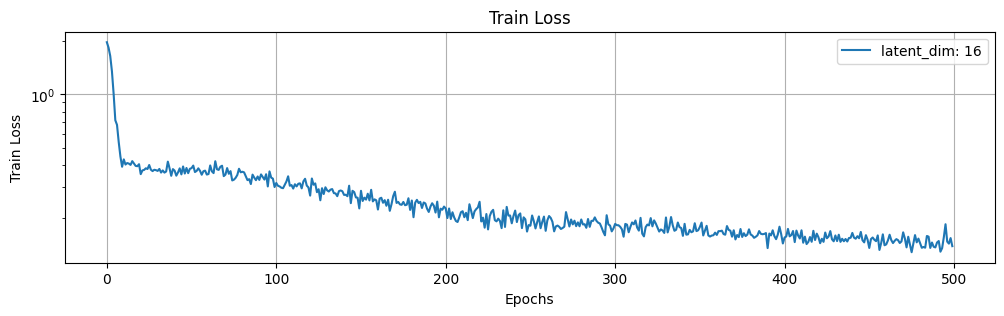

In [17]:
# Train the dynamics model
LATENT_DIM = 16
ACTION_DIM = 3
NUM_CHANNELS = 1
NUM_STEPS = 4

multi_step_latent_dynamics_model = SINDyDynamicsModel(latent_dim=LATENT_DIM, action_dim=ACTION_DIM, num_channels=NUM_CHANNELS)
# multi_step_latent_dynamics_model = LatentDynamicsModel(latent_dim=LATENT_DIM, action_dim=ACTION_DIM, num_channels=NUM_CHANNELS)

state_loss_fn = nn.MSELoss()
latent_loss_fn = nn.MSELoss()
multistep_loss = MultiStepLoss(state_loss_fn, latent_loss_fn, alpha=0.1)

# Compute normalization constants
train_loader, val_loader, norm_constants = process_data_multiple_step(collected_data, batch_size=512, num_steps=NUM_STEPS)


# --- Your code here
NUM_EPOCHS = 500
# NUM_EPOCHS = 300
LR = 0.7 * 1e-3


optimizer = optim.Adam(multi_step_latent_dynamics_model.parameters(), lr=LR)
pbar = tqdm(range(NUM_EPOCHS))
train_losses = []
for epoch_i in pbar:
    train_loss_i = 0.
    # --- Your code here
    for batch_idx, sample in enumerate(train_loader):
      # print("batch_idx = ", batch_idx)
      states_batch, actions_batch = sample["states"], sample["actions"]

      optimizer.zero_grad()
      loss = multistep_loss(multi_step_latent_dynamics_model, states_batch, actions_batch)
      loss.backward()
      optimizer.step()
      
    # ---
    train_loss_i += loss.item()
    pbar.set_description(f'Latent dim {LATENT_DIM} - Loss: {train_loss_i:.4f}')
    train_losses.append(train_loss_i)

losses = train_losses


# plot train loss and test loss:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
axes = [axes]
axes[0].plot(losses, label=f'latent_dim: {LATENT_DIM}')
axes[0].grid()
axes[0].legend()
axes[0].set_title('Train Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Train Loss')
axes[0].set_yscale('log')


# ---

# save model:
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'multi_step_latent_dynamics_model.pt')
torch.save(multi_step_latent_dynamics_model.state_dict(), save_path)

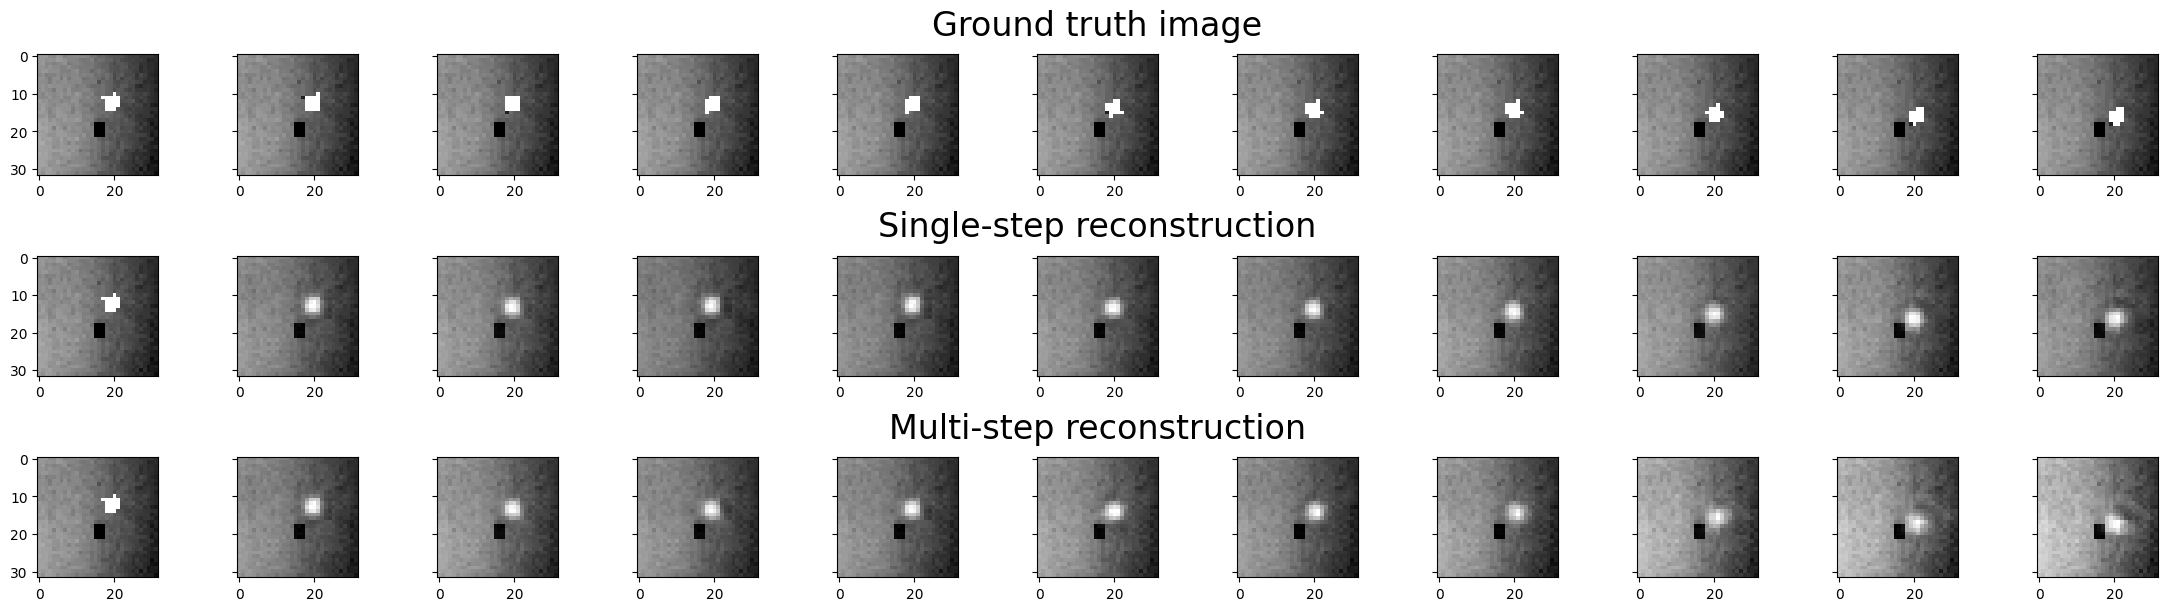

In [18]:
# Visualize the ability to perform  state and its reconstruction:
traj = collected_data[0]
evaluate_model_plot(multi_step_latent_dynamics_model, traj, norm_tr)

## Single-Step vs Multi-Step Loss

Now we will evalaute the difference between the multi-step model and the single-step model. You should see that the multi-step trained model has similar or better performance on the single-step loss but better performance on the multi-step loss.

**Grading Details**: We will test the performance of your model on `pushing_image_validation_data.npy`. You need to obtain at least the following loss values:
* Single-step model evaluated on single-step loss: 0.25
* Single-step model evaluated on multi-step loss: 0.37
* Multi-step model evaluated on single-step loss: 0.23
* Multi-step model evaluated on multi-step loss: 0.33

In [19]:
test_data = np.load(os.path.join(GOOGLE_DRIVE_PATH, 'pushing_image_validation_data.npy'), allow_pickle=True)
norm_tr = NormalizationTransform(norm_constants)

single_step_dataset = MultiStepDynamicsDataset(test_data, num_steps=1, transform=norm_tr)
single_step_loader = DataLoader(single_step_dataset, batch_size=len(single_step_dataset))

multi_step_dataset = MultiStepDynamicsDataset(test_data, num_steps=4, transform=norm_tr)
multi_step_loader = DataLoader(multi_step_dataset, batch_size=len(multi_step_dataset))

loss = MultiStepLoss(state_loss_fn, latent_loss_fn, alpha=1)

def test(model, val_loader, loss_fn) -> float:
    """
    Perfoms an epoch of model performance validation
    :param model: Pytorch nn.Module
    :param train_loader: Pytorch DataLoader
    :param loss: Loss function
    :return: val_loss <float> representing the average loss among the different mini-batches
    """
    val_loss = 0. # TODO: Modify the value
    # Initialize the validation loop
    model.eval()
    for batch in val_loader:
        loss = None
        states = batch['states']
        actions = batch['actions']
        loss = loss_fn(model, states, actions)
        val_loss += loss.item()
    return val_loss/len(val_loader)


print(f'Single-step model evaluated on single-step loss: {test(single_step_latent_dynamics_model, single_step_loader, loss)}')
print(f'Single-step model evaluated on multi-step loss: {test(single_step_latent_dynamics_model, multi_step_loader, loss)}')
print('')
print(f'Multi-step model evaluated on single-step loss: {test(multi_step_latent_dynamics_model, single_step_loader, loss)}')
print(f'Multi-step model evaluated on multi-step loss: {test(multi_step_latent_dynamics_model, multi_step_loader, loss)}')


Single-step model evaluated on single-step loss: 0.19534172117710114
Single-step model evaluated on multi-step loss: 0.30163538455963135

Multi-step model evaluated on single-step loss: 0.18531298637390137
Multi-step model evaluated on multi-step loss: 0.24674250185489655


# 5 - Latent Space Control (MPPI)  (30 points)

For this last part, we will use the learned model to drive the block to a goal location from image states using your latent dynamics model.

In [21]:
# Load the model
latent_dynamics_model = SINDyDynamicsModel(latent_dim=LATENT_DIM, action_dim=ACTION_DIM, num_channels=NUM_CHANNELS)
# latent_dynamics_model = LatentDynamicsModel(latent_dim=LATENT_DIM, action_dim=ACTION_DIM, num_channels=NUM_CHANNELS)
model_path = os.path.join(GOOGLE_DRIVE_PATH, 'multi_step_latent_dynamics_model.pt')
latent_dynamics_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## 5.1 Latent Space Controller (15 points)

In this part we will use the learned latent dynamics model to formulate a control problem in latent space.

MPPI will propagate the dyanamics in the latent space. Moreover, the cost function will be formulated in latent space, comparing how close states are to the goal in latent space.

**TODO**:
* Implement `latent_space_pushing_cost_function` in `learning_latent_dynamics.py`.
* Implement the missing parts from `PushingLatentController` in `learning_latent_dynamics.py`. In particular you need to implement the following methods:
    * `_compute_dynamics`
    * `_compute_costs`
    * `control`
    * `_wrap_state`
    * `_unwrap_state`
    
**GRADING GUIDE**:
We will execute your controller 10 times starting from the configuration shown below.  At least one execution needs to reach the goal. We consider that the object has reached the goal if the distance to the goal is less than the size of the object, i.e. `goal_distance < BOX_SIZE`.

In [22]:
import torch
a = torch.tensor([[1.0, 2.0, 3.0]])
b = torch.zeros_like(a)
print(a, b)
import torch.nn as nn
mse_loss = nn.MSELoss()
loss = mse_loss(a, b)
print(loss)
loss_n2 = torch.sum(torch.square(a - b))
print(loss_n2 / 3.0)

tensor([[1., 2., 3.]]) tensor([[0., 0., 0.]])
tensor(4.6667)
tensor(4.6667)


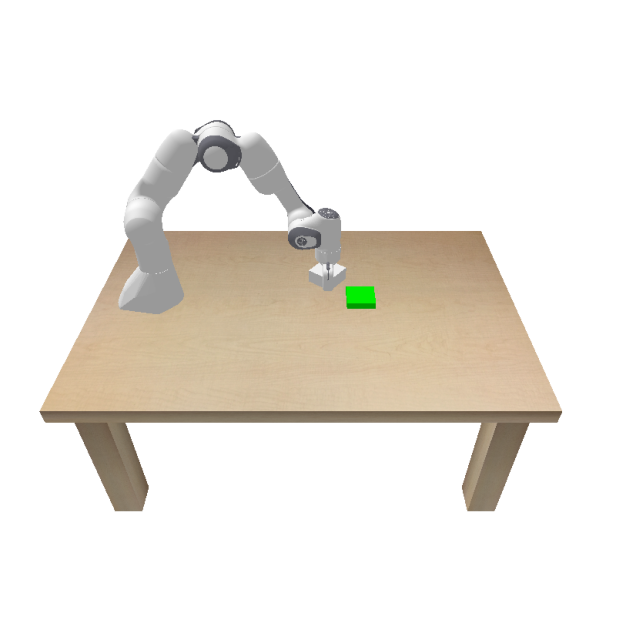

KeyboardInterrupt: ignored

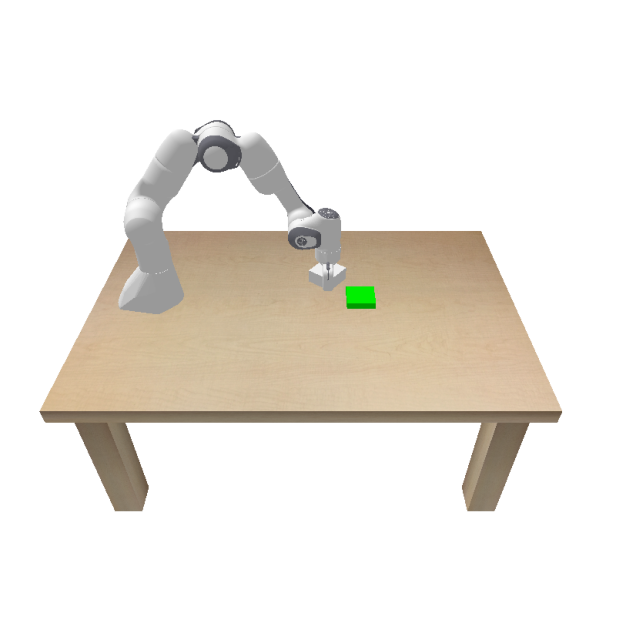

In [28]:
# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)


target_state = np.array([0.7, 0., 0.])

env = PandaImageSpacePushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=5, grayscale=True)
state_0 = env.reset()
env.object_target_pose = env._planar_pose_to_world_pose(target_state)
controller = PushingLatentController(env, latent_dynamics_model, latent_space_pushing_cost_function,norm_constants, num_samples=100, horizon=10)

state = state_0

# num_steps_max = 100
num_steps_max = 20

for i in range(num_steps_max):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    # check if we have reached the goal
    end_pose = env.get_object_pos_planar()
    goal_distance = np.linalg.norm(end_pose[:2]-target_state[:2]) # evaluate only position, not orientation
    goal_reached = goal_distance < BOX_SIZE
    if done or goal_reached:
        break

print(f'GOAL REACHED: {goal_reached}')
        
plt.close(fig)

## 5.2 - Image Space Controller (15 points)

In this final part, we will reformulate the controller to work in image space. MPPI will propagate the dynamics in image space and the costs will also be computed in the image space. We will use $\text{MSE}(\mathrm x_t, \mathrm x_g)$ to compute how close a state $\mathbf x_t$ is from the goal state $\mathrm x_g$.

**TODO**:
* Implement `img_space_pushing_cost_function` in `learning_latent_dynamics.py`.
* Implement the missing part from `PushingImgSpaceController` in `learning_latent_dynamics.py`. In particular you need to implement the following methods:
    * `_compute_dynamics`
    * `_compute_costs`
    * `control`
    * `_wrap_state`
    * `_unwrap_state`
    
**GRADING GUIDE**:
We will execute your controller 10 times on the configuration shown below.  At least one execution needs to reach the goal. We consider that the object has reached the goal if the distance to the goal is less than the size of the object, i.e. `goal_distance < BOX_SIZE`.

In [24]:
a = torch.rand(3, 3)
all_but_last_three_dim = a.shape[:-3]
print(all_but_last_three_dim)

torch.Size([])


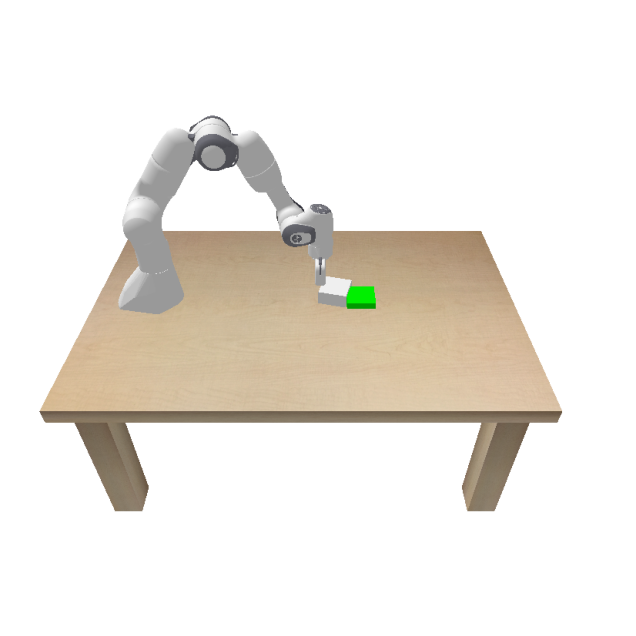

GOAL REACHED: True


In [26]:
# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)


target_state = np.array([0.7, 0., 0.])

env = PandaImageSpacePushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=5, grayscale=True)
state_0 = env.reset()
env.object_target_pose = env._planar_pose_to_world_pose(target_state)
controller = PushingImgSpaceController(env, latent_dynamics_model, img_space_pushing_cost_function, norm_constants, num_samples=100, horizon=10)

state = state_0

# num_steps_max = 100
num_steps_max = 30


goal_reached = False
for i in range(num_steps_max):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    
    # check if we have reached the goal
    end_pose = env.get_object_pos_planar()
    goal_distance = np.linalg.norm(end_pose[:2]-target_state[:2]) # evaluate only position, not orientation
    goal_reached = goal_distance < BOX_SIZE
    if done or goal_reached:
        break


print(f'GOAL REACHED: {goal_reached}')
        
        
plt.close(fig)

Congratulations, you have reached the end of this homework. Nice work! 
Please, submit all required files to [autograder.io](https://autograder.io)